# Assignment 3 - Supervised Learning: model training and evaluation {-}

## *Genesis Ziheng Qu* {-}
Netid: ZQ46

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning Objectives: {-}
This assignment will provide structured practice to help enable you to...
1. Understand the primary workflow in machine learning: (1) identifying a hypothesis function set of models, (2) determining a loss/cost/error/objective function to minimize, and (3) minimizing that function through gradient descent
2. Understand the inner workings of logistic regression and how linear models for classification can be developed.
3. Gain practice in implementing machine learning algorithms from the most basic building blocks to understand the math and programming behind them to achieve practical proficiency with the techniques
4. Implement batch gradient descent and become familiar with how that technique is used and its dependence on the choice of learning rate
5. Evaluate supervised learning algorithm performance through ROC curves and using cross validation
6. Apply regularization to linear models to improve model generalization performance

In [49]:
# Set plot configurations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

# 1 {-}
## Classification using logistic regression: build it from the ground up {-}
**[60 points]**

This exercise will walk you through the full life-cycle of a supervised machine learning classification problem. Classification problem consists of two features/predictors (e.g. petal width and petal length) and your goal is to predict one of two possible classes (class 0 or class 1). You will build, train, and evaluate the performance of a logistic regression classifier on the data provided. Before you begin any modeling, you'll load and explore your data in Part I to familiarize yourself with it - and check for any missing or erroneous data. Then, in Part II, we will review an appropriate hypothesis set of functions to fit to the data: in this case, logistic regression. In Part III, we will derive an appropriate cost function for the data (spoiler alert: it's cross-entropy) as well as the gradient descent update equation that will allow you to optimize that cost function to identify the parameters that minimize the cost for the training data. In Part IV, all the pieces come together and you will implement your logistic regression model class including methods for fitting the data using gradient descent. Using that model you'll test it out and plot learning curves to verify the model learns as you train it and to identify and appropriate learning rate hyperparameter. Lastly, in Part V you will apply the model you designed, implemented, and verified to your actual data and evaluate and visualize its generalization performance as compared to a KNN algorithm. **When complete, you will have accomplished learning objectives 1-5 above!**

### I. Load, prepare, and plot your data {-}
You are given some data for which you are tasked with constructing a classifier. The first step when facing any machine learning project: look at your data!

**(a)** Load the data. 
- In the data folder in the same directory of this notebook, you'll find the data in `A3_Q1_data.csv`. This file contains the binary class labels, $y$, and the features $x_1$ and $x_2$.
- Divide your data into a training and testing set where the test set accounts for 30 percent of the data and the training set the remaining 70 percent.  
- Plot the training data by class. 
- Comment on the data: do the data appear separable? May logistic regression be a good choice for these data? Why or why not?

**(b)** Do the data require any preprocessing due to missing values, scale differences (e.g. different ranges of values), etc.? If so, how did you handle these issues?

Next, we walk through our key steps for model fitting: choose a hypothesis set of models to train (in this case, logistic regression); identify a cost function to measure the model fit to our training data; optimize model parameters to minimize cost (in this case using gradient descent). Once we've completed model fitting, we will evaluate the performance of our model and compare performance to another approach (a KNN classifier).

**ANSWER**


#### (a) Loading in data {-}

In [50]:
# Import pandas, numpy and sklearn modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load in the data
q1_data = pd.read_csv(
    "https://github.com/kylebradbury/ids705/raw/"
    "main/assignments/data/A3_Q1_data.csv"
)

# Check shape of q1_data
print(f"The shape of the dataset is {q1_data.shape}.")

# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    q1_data[["x1", "x2"]], q1_data["y"], random_state=4, test_size=0.3
)

# Check the split sample sizes
print(f"The shape of the training X dataset is {X_train.shape}.")
print(f"The shape of the test y dataset is {X_test.shape}.")
print(f"The shape of the training X dataset is {y_train.shape}.")
print(f"The shape of the test y dataset is {y_test.shape}.")


The shape of the dataset is (200, 3).
The shape of the training X dataset is (140, 2).
The shape of the test y dataset is (60, 2).
The shape of the training X dataset is (140,).
The shape of the test y dataset is (60,).


> After checking the dimensions of the full dataset and then the training and test datasets separately, we see that the dataset is split 30-70 between the training set and the test set.

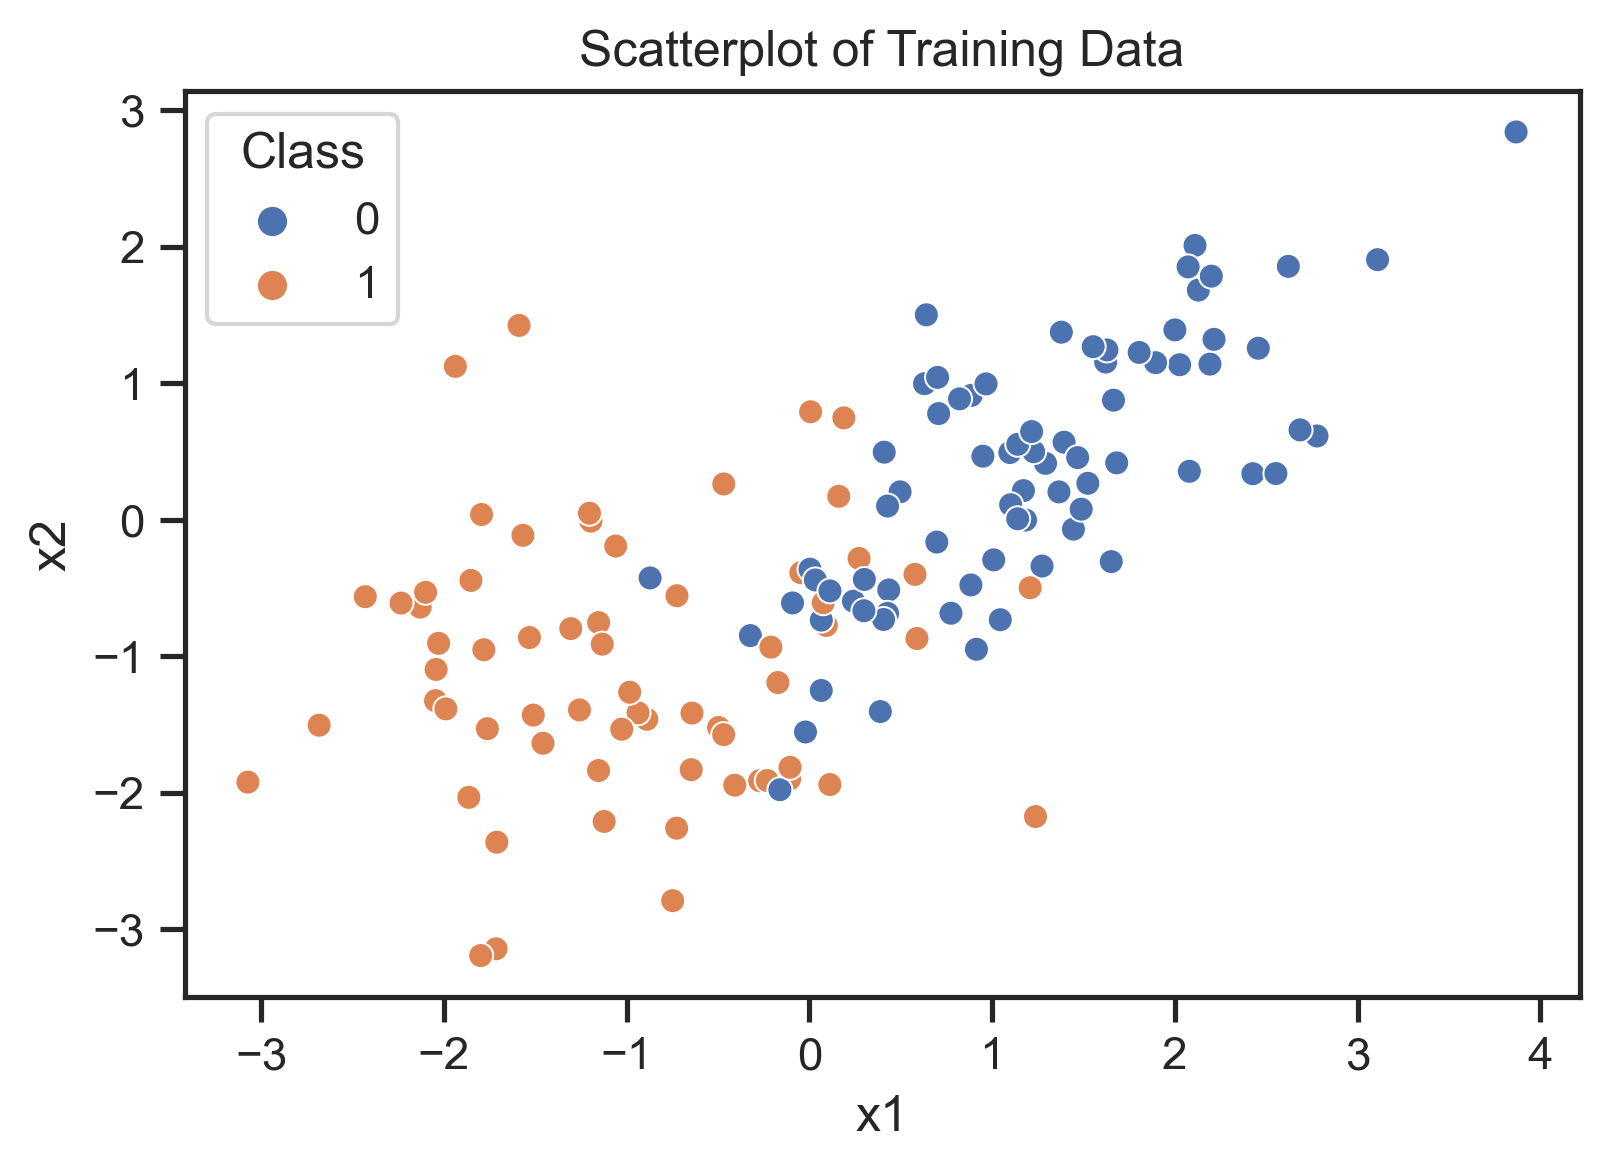

In [51]:
# Plot the training data by class
sns.scatterplot(x=X_train["x1"], y=X_train["x2"], hue=y_train)
plt.legend(title="Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Scatterplot of Training Data")
plt.show()


> The two classes in the training class look approximately linearly separable. While the two classes have some overlap on the plane formed by x1 and x2, you can draw a line between the two classes and distinguish them with relatively high accuracy. Based on these observations, logistic regression would appear to be a good hypothesis set.  

### (b) Data Validation {-}

In [52]:
# print out mean and std of x1 and x2
print(
    f"The mean of x1 is {q1_data['x1'].mean():.2f}, and its "
    f"standard deviation is {q1_data['x1'].std():.2f}."
)
print(
    f"The mean of x2 is {q1_data['x2'].mean():.2f}, and its "
    f"standard deviation is {q1_data['x2'].std():.2f}."
)
# print out the range of x1 and x2
print(
    f"The minimum of x1 is {q1_data['x1'].min():.2f}, and its "
    f"maximum is {q1_data['x1'].max():.2f}."
)
print(
    f"The minimum of x2 is {q1_data['x2'].min():.2f}, and its "
    f"maximum is {q1_data['x2'].max():.2f}."
)
# print out number of null values in the data
print(f"There are {q1_data.isna().sum().sum()} missing values in the data.")


The mean of x1 is 0.15, and its standard deviation is 1.41.
The mean of x2 is -0.39, and its standard deviation is 1.22.
The minimum of x1 is -3.21, and its maximum is 3.87.
The minimum of x2 is -3.19, and its maximum is 3.10.
There are 0 missing values in the data.


> There are no missing values in the whole dataset so we do not need to remove any rows or impute any missing data. The mean and standard deviation of the features in the data are similar, the means of both variables are around 0 and the standard deviations are a little above 1. The two variables also have similar ranges. Therefore it's not necessary to scale the data.

### II. Stating the hypothesis set of models to evaluate (we'll use logistic regression) {-}

Given that our data consists of two features, our logistic regression problem will be applied to a two-dimensional feature space. Recall that our logistic regression model is:

$$f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

where the sigmoid function is defined as $\sigma(x) = \dfrac{e^x}{1+e^{x}}= \dfrac{1}{1+e^{-x}}$. Also, since this is a two-dimensional problem, we define $\mathbf{w}^{\top} \mathbf{x}_i = w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ and here, $\mathbf{x}_i=[x_{i,0}, x_{i,1}, x_{i,2}]^{\top}$, and $x_{i,0} \triangleq 1$

Remember from class that we interpret our logistic regression classifier output (or confidence score) as the conditional probability that the target variable for a given sample $y_i$ is from class "1", given the observed features, $\mathbf{x}_i$. For one sample, $(y_i, \mathbf{x}_i)$, this is given as:

$$P(Y=1|X=\mathbf{x}_i) = f(\mathbf{x}_i,\mathbf{w})=\sigma(\mathbf{w}^{\top} \mathbf{x}_i)$$

In the context of maximizing the likelihood of our parameters given the data, we define this to be the likelihood function $L(\mathbf{w}|y_i,\mathbf{x}_i)$, corresponding to one sample observation from the training dataset.

*Aside: the careful reader will recognize this expression looks different from when we talk about the likelihood of our data given the true class label, typically expressed as $P(x|y)$, or the posterior probability of a class label given our data, typically expressed as $P(y|x)$. In the context of training a logistic regression model, the likelihood we are interested in is the likelihood function of our logistic regression **parameters**, $\mathbf{w}$. It's our goal to use this to choose the parameters to maximize the likelihood function.*

**No output is required for this section - just read and use this information in the later sections.**

### III. Find the cost function that we can use to choose the model parameters, $\mathbf{w}$, that best fit the training data. {-}

**(c)** What is the likelihood function that corresponds to all the $N$ samples in our training dataset that we will wish to maximize? Unlike the likelihood function written above which gives the likelihood function for a *single training data pair* $(y_i, \mathbf{x}_i)$, this question asks for the likelihood function for the *entire training dataset* $\{(y_1, \mathbf{x}_1), (y_2, \mathbf{x}_2), ..., (y_N, \mathbf{x}_N)\}$. 

**(d)** Since a logarithm is a monotonic function, maximizing the $f(x)$ is equivalent to maximizing $\ln [f(x)]$. Express the likelihood from the last question as a cost function of the model parameters, $C(\mathbf{w})$; that is the negative of the logarithm of the likelihood. Express this cost as an average cost per sample (i.e. divide your final value by $N$), and use this quantity going forward as the cost function to optimize.

**(e)** Calculate the gradient of the cost function with respect to the model parameters $\nabla_{\mathbf{w}}C(\mathbf{w})$. Express this in terms of the partial derivatives of the cost function with respect to each of the parameters, e.g. $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2}\right]$. 

To simplify notation, please use $\mathbf{w}^{\top}\mathbf{x}$ instead of writing out $w_0 x_{i,0} + w_1 x_{i,1} + w_2 x_{i,2}$ when it appears each time (where $x_{i,0} = 1$ for all $i$). You are also welcome to use $\sigma()$ to represent the sigmoid function. Lastly, this will be a function the features, $x_{i,j}$ (with the first index in the subscript representing the observation and the second the feature; targets, $y_i$; and the logistic regression model parameters, $w_j$.

**(f)** Write out the gradient descent update equation. This should clearly express how to update each weight from one step in gradient descent $w_j^{(k)}$ to the next $w_j^{(k+1)}$.  There should be one equation for each model logistic regression model parameter (or you can represent it in vectorized form). Assume that $\eta$ represents the learning rate.

**Answer**


##### (c) Likelihood function of samples {-}


>  The likelihood function is the likelihood of observing a given sequence of observations $\mathbf{x}$ given the responses $\mathbf{y}$. If $\mathbf{y}_i = 1$ as illustrated in section II, the likelihood of that given observation is $\sigma(\mathbf{w}^T\mathbf{x}_i)$. However, if $\mathbf{y}_i = 0$, then the likelihood of that observation is $1 - \sigma(\mathbf{w}^T\mathbf{x}_i)$ instead. Assuming that each sample is independent, likelihood function of all N samples in our training dataset is given by the product of all the marginal likelihood functions. Therefore, the likelihood function is given by:
> $$\prod_{i=1}^N\sigma(\mathbf{w}^T\mathbf{x}_i)^{y_i} (1 - \sigma(\mathbf{w}^T\mathbf{x}_i))^{1-y_i}$$

##### (d) Expressing the likelihood function as a cost function {-}

> We begin by taking the negative of the logged likelihood function and writing it as a function of the model parameter $\mathbf{w}$.
> $$-log(\prod_{i=1}^N \sigma(\mathbf{w}^T\mathbf{x}_i)^{y_i} (1 - \sigma(\mathbf{w}^T\mathbf{x}_i))^{1-y_i})$$
> Which is equivalent to:
> $$ -\sum_{i=1}^N (y_i log(\sigma(\mathbf{w}^T\mathbf{x}_i)) + (1-y_i)log(1 - \sigma(\mathbf{w}^T\mathbf{x}_i)))$$
> We then get the average cost per sample by dividing this function by the number of samples:
> $$ - \frac{1}{N}\sum_{i=1}^N (y_i log(\sigma(\mathbf{w}^T\mathbf{x}_i)) + (1-y_i)log(1 - \sigma(\mathbf{w}^T\mathbf{x}_i)))$$
> Knowing that $\sigma(x) = \dfrac{1}{1+e^{-x}}$, the above equation is equal to:
> $$ =  - \frac{1}{N}\sum_{i=1}^N y_i log(\frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}) + (1-y_i)log(1 - \frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}})$$
>  $$ = - \frac{1}{N}\sum_{i=1}^N y_i log(\frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}) + (1-y_i)log(\frac{1 + e^{-\mathbf{w}^T\mathbf{x}_i} - 1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}})$$
> $$ = - \frac{1}{N}\sum_{i=1}^N y_i log(\frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}) + (1-y_i)log(\frac{e^{-\mathbf{w}^T\mathbf{x}_i}}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}})$$
> $$ = - \frac{1}{N}\sum_{i=1}^N  log(\frac{e^{-\mathbf{w}^T\mathbf{x}_i}}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}) + y_i log(\frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}} \frac{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}{e^{-\mathbf{w}^T\mathbf{x}_i}})$$
> $$ = - \frac{1}{N}\sum_{i=1}^N  log(\frac{e^{-\mathbf{w}^T\mathbf{x}_i}}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}}) + y_i log( \frac{1}{e^{-\mathbf{w}^T\mathbf{x}_i}})$$
> $$ = - \frac{1}{N}\sum_{i=1}^N  log(\frac{e^{-\mathbf{w}^T\mathbf{x}_i}}{1 + e^{-\mathbf{w}^T\mathbf{x}_i}} \frac{e^{\mathbf{w}^T\mathbf{x}_i}}{ e^{\mathbf{w}^T\mathbf{x}_i}}) + y_i log( \frac{1}{e^{-\mathbf{w}^T\mathbf{x}_i}})$$
> $$ = - \frac{1}{N}\sum_{i=1}^N  log(\frac{1}{1 + e^{\mathbf{w}^T\mathbf{x}_i}}) + y_i (log(1) - log(e^{-\mathbf{w}^T\mathbf{x}_i}))$$
> $$ = - \frac{1}{N}\sum_{i=1}^N  log(1) - log(1 + e^{\mathbf{w}^T\mathbf{x}_i}) + y_ilog(1) + y_i \mathbf{w}^T\mathbf{x}_i$$
> Because $log(1) = 0$:
> $$ = - \frac{1}{N}\sum_{i=1}^N - log(1 + e^{\mathbf{w}^T\mathbf{x}_i}) + y_i \mathbf{w}^T\mathbf{x}_i$$
> $$ = \frac{1}{N}\sum_{i=1}^N log(1 + e^{\mathbf{w}^T\mathbf{x}_i}) - y_i \mathbf{w}^T\mathbf{x}_i$$

##### (e) Deriving the gradient of the cost function {-}

> To get the gradient of the cost function, we simply take the derivative of the cost function with respect to each element of the logistic regression weights $\mathbf{w}$ where $\nabla_{\mathbf{w}}C(\mathbf{w}) = \left[\dfrac{\partial C}{\partial w_0}, \dfrac{\partial C}{\partial w_1}, \dfrac{\partial C}{\partial w_2},... \right]$
> Therefore, 
> $$\nabla_{\mathbf{w}}C(\mathbf{w}) = \nabla_{\mathbf{w}} (\frac{1}{N}\sum_{i=1}^N log(1 + e^{\mathbf{w}^T\mathbf{x}_i}) - y_i \mathbf{w}^T\mathbf{x}_i)$$
> Say that the weight vector $\mathbf{w}$ has $p$ elements, we take the derivative of each $\mathbf{w}$ from $w = 0...j...p$ such that for each $w$:
> $$ \dfrac{\partial C}{\partial w_j} = \frac{1}{N} \sum_{i=1}^N \frac{e^{\mathbf{w}^T\mathbf{x_i}}}{1 + e^{\mathbf{w}^T\mathbf{x_i}}} \mathbf{x_{i,j}} - \mathbf{y_i}\mathbf{x_{i,j}} $$
> $$  = \frac{1}{N} \sum_{i=1}^N \sigma(\mathbf{w}^T\mathbf{x}_i) \mathbf{x_{i,j}} - \mathbf{y_i}\mathbf{x_{i,j}} $$
> $$  = \frac{1}{N} \sum_{i=1}^N (\sigma(\mathbf{w}^T\mathbf{x}_i) - \mathbf{y_i})\mathbf{x_{i,j}} $$
> Therefore, the gradient of the cost function with w0, w1, and w2 – $\nabla_{\mathbf{w}}C(\mathbf{w})$ is :
$$\left[ \frac{1}{N} \sum_{i=1}^N (\sigma(\mathbf{w}^T\mathbf{x}_i) - \mathbf{y_i}) \mathbf{x_{i,0}}, \frac{1}{N} \sum_{i=1}^N (\sigma(\mathbf{w}^T\mathbf{x}_i) - \mathbf{y_i}) \mathbf{x_{i,1}},\frac{1}{N} \sum_{i=1}^N (\sigma(\mathbf{w}^T\mathbf{x}_i) - \mathbf{y_i}) \mathbf{x_{i,2}} \right] $$


##### (f) Gradient descent update question {-}
> To update the weight vector based on its gradient, we take a step to the steepest descent of that gradient space. Mathematically, it means subtracting the current weights by the gradient of the weight vector w.r.t. the cost function, multiplied by a learning rate. We have a learning rate to moderate how large of a step we are taking so we do not miss the convex of the cost function. 
> Where $w_j^{(k)}$ is the current weight vector, $\eta$ os the learning rate of the gradient descent, $w_j^{(k+1)}$ – the updated gradient vector is given by:
> $$w_j^{(k+1)} = w_j^{(k)} - \frac{\eta}{N} \sum_{i=1}^N (\sigma(\mathbf{w}^{(k)T}\mathbf{x}_i) - \mathbf{y_i})\mathbf{x_{i,j}}$$

### IV. Implement gradient descent and your logistic regression algorithm {-}

**(g)** Implement your logistic regression model. 
- You are provided with a template, below, for a class with key methods to help with your model development. It is modeled on the Scikit-Learn convention. For this, you only need to create a version of logistic regression for the case of two feature variables (i.e. two predictors).
- Create a method called `sigmoid` that calculates the sigmoid function
- Create a method called `cost` that computes the cost function $C(\mathbf{w})$ for a given dataset and corresponding class labels. This should be the **average cost** (make sure your total cost is divided by your number of samples in the dataset).
- Create a method called `gradient_descent` to run **one step** of gradient descent on your training data. We'll refer to this as "batch" gradient descent since it takes into account the gradient based on all our data at each iteration of the algorithm. 
- Create a method called `fit` that fits the model to the data (i.e. sets the model parameters to minimize cost) using your `gradient_descent` method. In doing this we'll need to make some assumptions about the following:
    - Weight initialization. What should you initialize the model parameters to? For this, randomly initialize the weights to a different values between 0 and 1.
    - Learning rate. How slow/fast should the algorithm step towards the minimum? This you will vary in a later part of this problem.
    - Stopping criteria. When should the algorithm be finished searching for the optimum? There are two stopping criteria: small changes in the gradient descent step size and a maximum number of iterations. The first is whether there was a sufficiently small change in the gradient; this is evaluated as whether the magnitude of the step that the gradient descent algorithm takes changes by less than $10^{-6}$ between iterations. Since we have a weight vector, we can compute the change in the weight by evaluating the $L_2$ norm (Euclidean norm) of the change in the vector between iterations. From our gradient descent update equation we know that mathematically this is $||-\eta\nabla_{\mathbf{w}}C(\mathbf{w})||$. The second criterion is met if a maximum number of iterations has been reach (5,000 in this case, to prevent infinite loops from poor choices of learning rates).
    - Design your approach so that at each step in the gradient descent algorithm you evaluate the cost function for both the training and the test data for each new value for the model weights. You should be able to plot cost vs gradient descent iteration for both the training and the test data. This will allow you to plot "learning curves" that can be informative for how the model training process is proceeding.
- Create a method called `predict_proba` that predicts confidence scores (that can be thresholded into the predictions of the `predict` method.
- Create a method called `predict` that makes predictions based on the trained model, selecting the most probable class, given the data, as the prediction, that is class that yields the larger $P(y|\mathbf{x})$.
- (Optional, but recommended) Create a method called `learning_curve` that produces the cost function values that correspond to each step from a previously run gradient descent operation.
- (Optional, but recommended) Create a method called `prepare_x` which appends a column of ones as the first feature of the dataset $\mathbf{X}$ to account for the bias term ($x_{i,1}=1$).

This structure is strongly encouraged; however, you're welcome to adjust this to your needs (adding helper methods, modifying parameters, etc.).

**Answer**

##### (g) Creating the Logistic Regression Class {-}

In [53]:
# Logistic regression class
class Logistic_regression:
    # Class constructor
    def __init__(self):
        """Initialize a logistic regression instance, 
        define weight, 
        saved weights, training cost, test cost"""
        self.w = None  # logistic regression weights
        self.saved_w = []  # Since this is a small problem, 
        # we can save the weights
        #  at each iteration of gradient descent to build our
        #  learning curves
        self.training_cost = []
        self.test_cost = []
        # returns nothing
        pass

    # Method for calculating the sigmoid function of w^T X 
    # for an input set of weights
    def sigmoid(self, X, w):
        """Returns the value of the sigmoid"""
        # returns the value of the sigmoid
        return 1 / (1 + np.exp(-w @ X.T))

    # Cost function for an input set of weights
    def cost(self, X, y, w):
        """Returns the average cross entropy cost"""
        # returns the average cross entropy cost
        cost_by_element = np.log(1 + np.exp(w @ X.T)) - y * (w @ X.T)
        return cost_by_element.mean()

    # Update the weights in an iteration of gradient descent
    def gradient_descent(self, X, y, lr):
        """Compute one iteration of gradient descent, 
        returns a scalar of the magnitude of the Eurclidian norm"""
        # returns a scalar of the magnitude of the Euclidean norm
        #  of the change in the weights during one gradient descent step
        # Get the number of observations N
        n = X.shape[0]
        # Calculate the gradient for the current weights
        gradient = ((self.sigmoid(X=X, w=self.w) - y) @ X) / n
        # Update the weight using the gradient
        self.w -= gradient * lr
        # Store the weights in the saved_w
        self.saved_w.append(list(self.w))
        # Calculate the Euclidean norm
        norm = np.sqrt(((gradient * lr) ** 2).sum())
        return norm

    # Fit the logistic regression model to the data through gradient descent
    def fit(self, X, y, lr, delta_thresh=1e-6, max_iter=5000, verbose=False):
        """Fit a logistic regression function, given X, y training data
        a learning rate lr, the threshold and maximum iteration for 
        stopping the gradient descent algorithm, and verbosity"""
        # Note the verbose flag enables you to print out the 
        # weights at each iteration
        #  (optional - but may help with one of the questions)
        # Initialize a delta value and iteration count
        delta = 1
        iter = 0
        X_new = self.prepare_x(X)
        # Get the number of observations and number of predictors
        n = X_new.shape[0]
        p = X_new.shape[1]
        # Initialize the weight vector
        w_init = np.random.random(size=p)
        self.w = w_init
        self.saved_w.append(list(w_init))
        self.training_cost.append(self.cost(X=X_new, y=y, w=w_init))
        # Iterate until reaching delta_thresh or max_iter
        while (delta > delta_thresh) & (iter < max_iter):
            # Perform one iteration of gradient descent
            delta = self.gradient_descent(X=X_new, y=y, lr=lr)
            iter += 1
            # Append the training cost to the training cost list
            self.training_cost.append(self.cost(X=X_new, y=y, w=self.w))
            if verbose:
                print(f"The weights in iteration {iter} are:"
                f" {list(self.w.round(3))}")
            pass
        pass

    # Use the trained model to predict the confidence scores 
    # (prob of positive class in this case)
    def predict_proba(self, X):
        """Returns the confidence score for the each sample"""
        X_new = self.prepare_x(X)
        probs = self.sigmoid(X=X_new, w=self.w)
        return np.array(probs)

    # Use the trained model to make binary predictions
    def predict(self, X, thresh=0.5):
        """Given a threshold, returns a binary prediction 
        for each sample"""
        # returns a binary prediction for each sample
        # Get the probabilities for each sample
        probs = self.predict_proba(X=X)
        # Make decisions based on the threshhold
        preds = np.where(probs > thresh, 1, 0)
        return preds

    # Stores the learning curves from saved weights from gradient descent
    def learning_curve(self, X_test, y_test):
        """returns the value of the cost function 
        from each step in gradient descent"""
        train_cost = np.array(self.training_cost)
        # Get the test cost matrix
        X_test_new = self.prepare_x(X_test)
        saved_w = np.array(self.saved_w)
        extended_y = np.tile(y_test, (saved_w.shape[0], 1))
        cost_mat_test = np.log(1 + np.exp(saved_w @ X_test_new.T)
        ) - extended_y * (
            saved_w @ X_test_new.T
        )
        # output the test cost
        test_cost = cost_mat_test.mean(axis=1)
        return train_cost, test_cost

    # Appends a column of ones as the first feature to 
    # account for the bias term
    def prepare_x(self, X):
        """Returns the X with a new feature of all ones"""
        ones = np.ones(X.shape[0]).reshape((-1, 1))
        new_X = np.concatenate((ones, X), axis=1)
        return new_X


**(h)** Choose a learning rate and fit your model. Learning curves are a plot of metrics of model performance evaluated through the process of model training to provide insight about how model training is proceeding. Show the learning curves for the gradient descent process for learning rates of $\{10^{-0}, 10^{-2}, 10^{-4}\}$. For each learning rate plot the learning curves by plotting **both the training and test data average cost** as a function of each iteration of gradient descent. You should run the model fitting process until it completes (up to 5,000 iterations of gradient descent). Each of the 6 resulting curves (train and test average cost for each learning rate) should be plotted on the **same set of axes** to enable direct comparison. *Note: make sure you're using average cost per sample, not the total cost*.
- Try running this process for a really big learning rate for this problem: $10^2$. Look at the weights that the fitting process generates over the first 50 iterations and how they change. Either print these first 50 iterations as console output or plot them. What happens? How does the output compare to that corresponding to a learning rate of $10^0$ and why?
- What is the impact that the different values of learning have on the speed of the process and the results? 
- Of the options explored, what learning rate do you prefer and why?
- Use your chosen learning rate for the remainder of this problem.

**Answer**



##### (h) Choosing a learning curve {-}

> Below, we fit three separate logistic models by using three different learning rates in gradient descent. 

In [54]:
# define the three learning rates
lr_0 = 1e0
lr_1 = 1e-2
lr_2 = 1e-4

# Set random seed
np.random.seed(4)

# fit the model with the three learning rates
regression_lr_0 = Logistic_regression()
regression_lr_0.fit(X=X_train, y=y_train, lr=lr_0, delta_thresh=0)
regression_lr_1 = Logistic_regression()
regression_lr_1.fit(X=X_train, y=y_train, lr=lr_1, delta_thresh=0)
regression_lr_2 = Logistic_regression()
regression_lr_2.fit(X=X_train, y=y_train, lr=lr_2, delta_thresh=0)


# get the training and testing cost curves out of each model
train_cost_lr_0, test_cost_lr_0 = regression_lr_0.learning_curve(
    X_test, y_test)
train_cost_lr_1, test_cost_lr_1 = regression_lr_1.learning_curve(
    X_test, y_test)
train_cost_lr_2, test_cost_lr_2 = regression_lr_2.learning_curve(
    X_test, y_test)


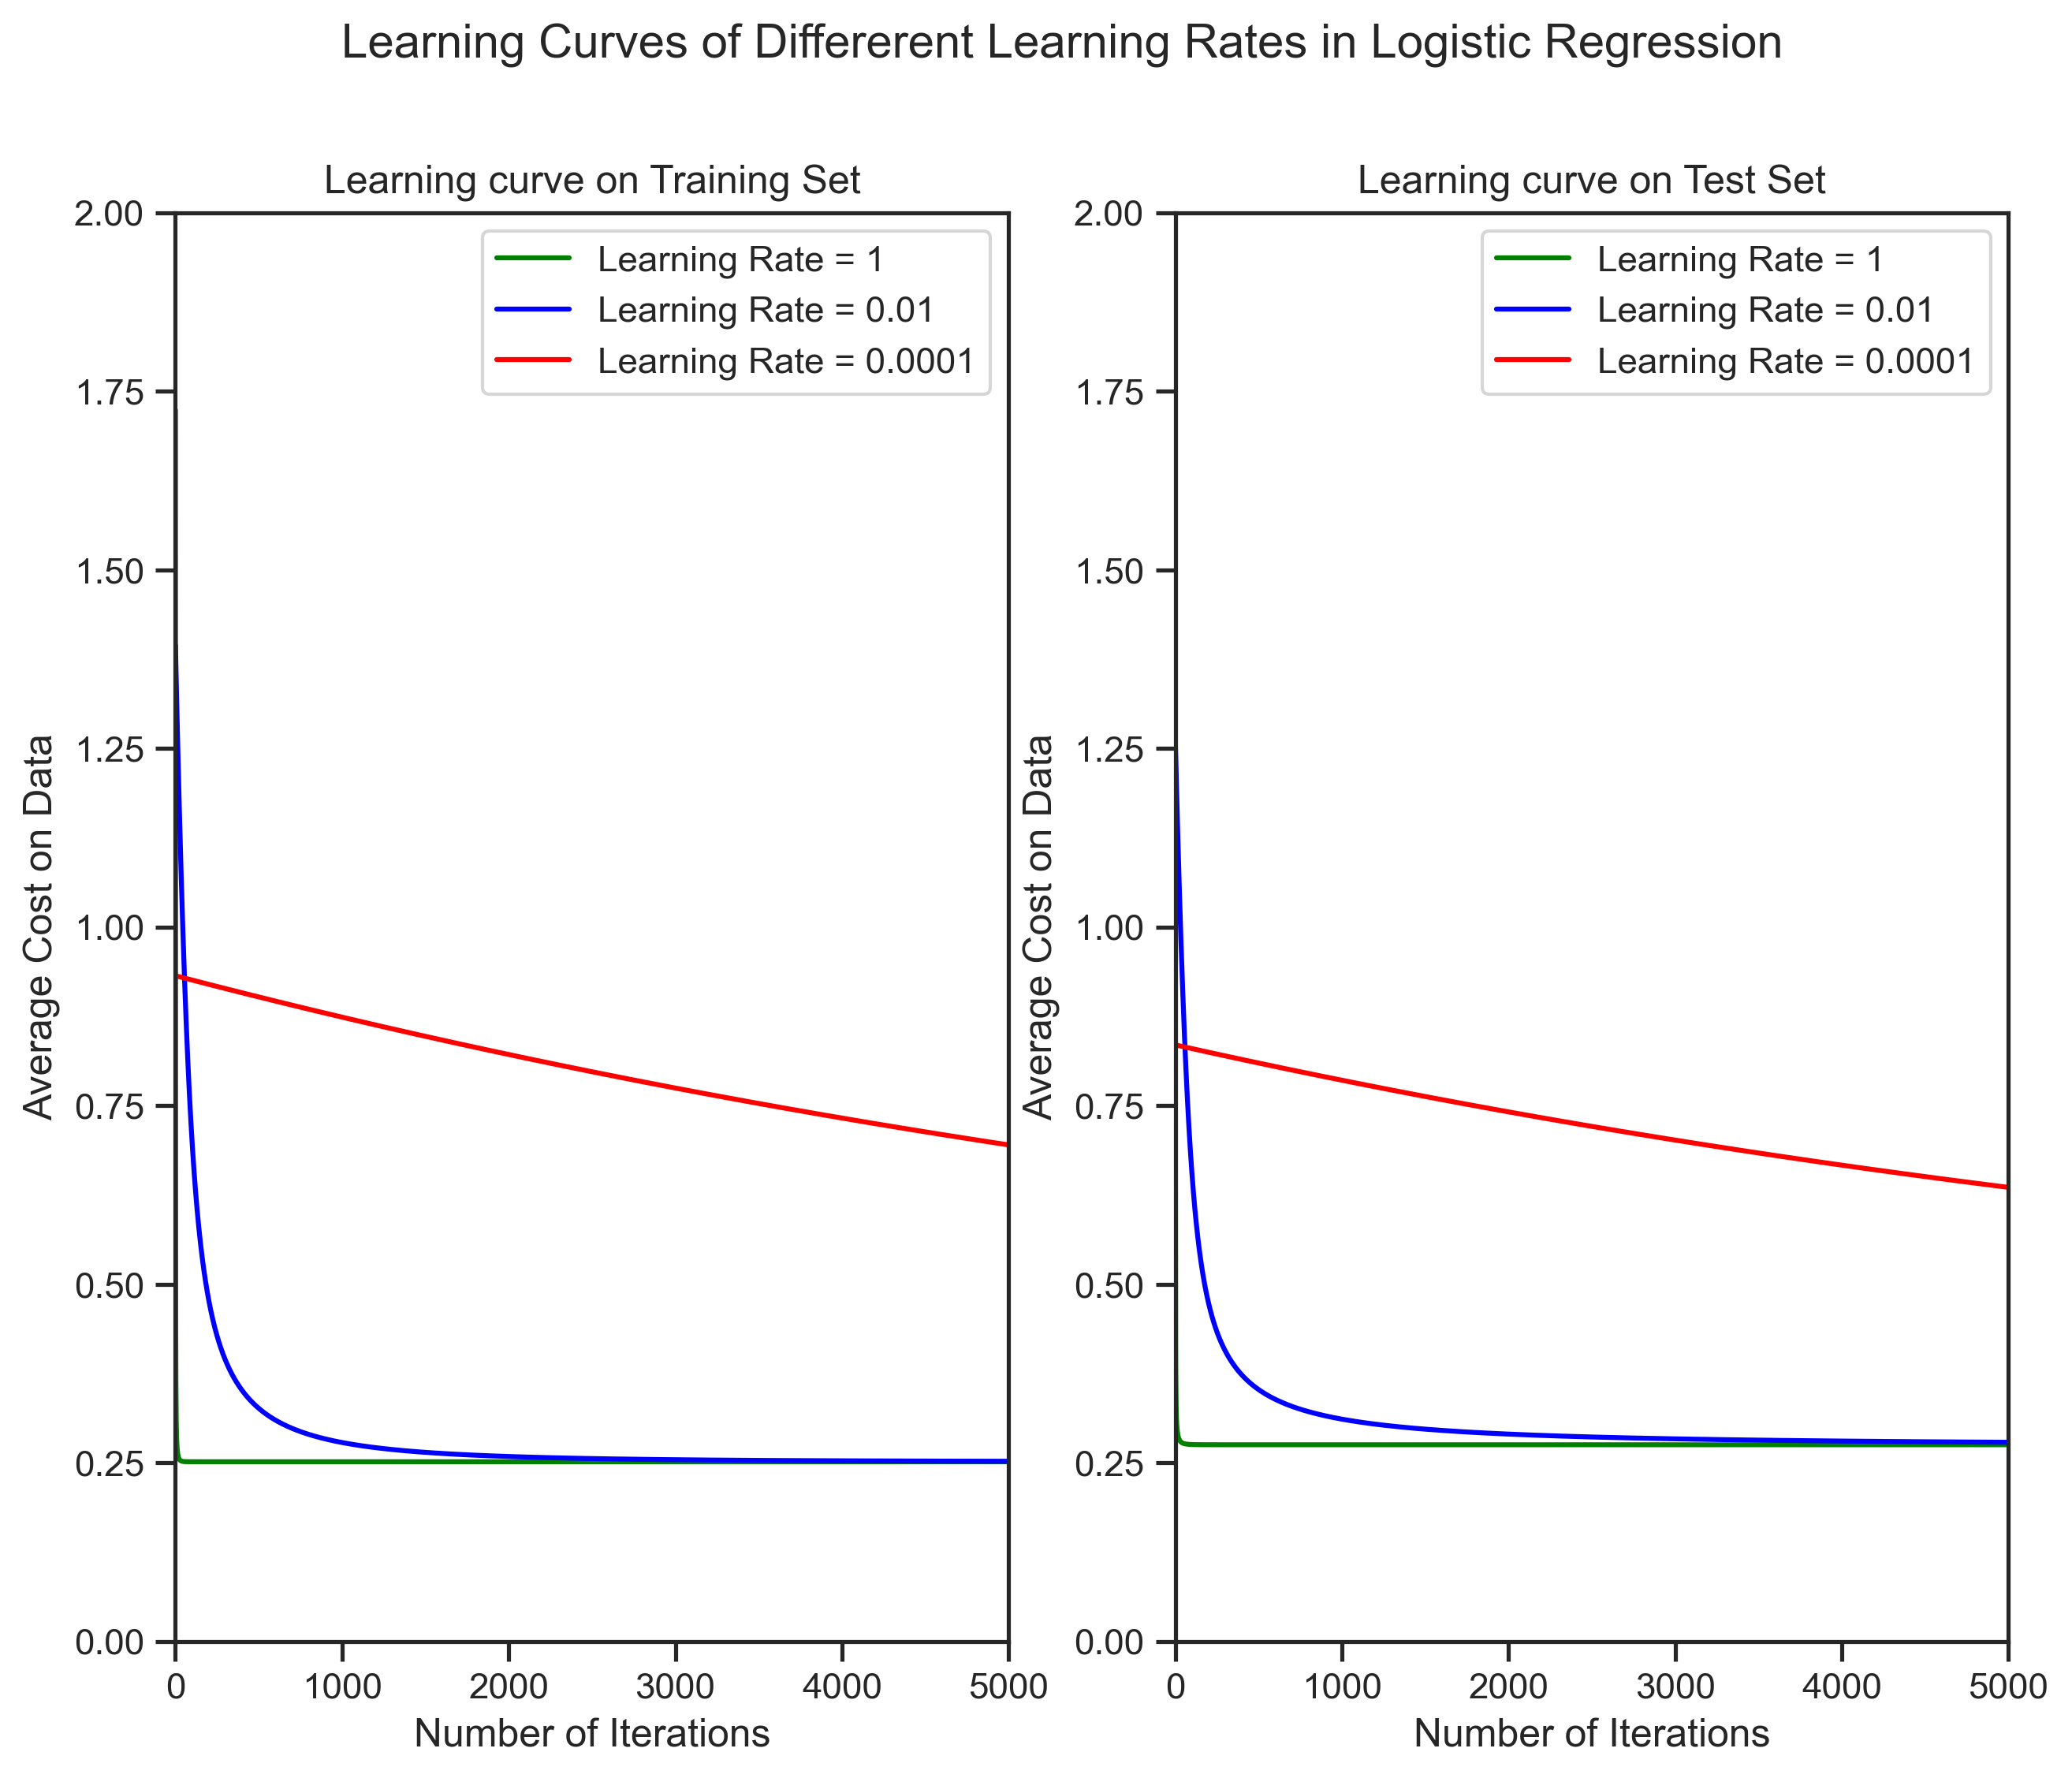

In [55]:
# Plot the training and testing learning curves
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
axes[0].plot(train_cost_lr_0, c="green", label="Learning Rate = 1")
axes[0].plot(train_cost_lr_1, c="blue", label="Learning Rate = 0.01")
axes[0].plot(train_cost_lr_2, c="red", label="Learning Rate = 0.0001")
axes[0].set_title("Learning curve on Training Set")
axes[0].set_xlim([0, 5000])
axes[0].set_ylim([0, 2])
axes[0].set_xlabel("Number of Iterations")
axes[0].set_ylabel("Average Cost on Data")
axes[0].legend()
axes[1].plot(test_cost_lr_0, c="green", label="Learning Rate = 1")
axes[1].plot(test_cost_lr_1, c="blue", label="Learning Rate = 0.01")
axes[1].plot(test_cost_lr_2, c="red", label="Learning Rate = 0.0001")
axes[1].set_title("Learning curve on Test Set")
axes[1].set_xlim([0, 5000])
axes[1].set_ylim([0, 2])
axes[1].set_xlabel("Number of Iterations")
axes[1].set_ylabel("Average Cost on Data")
axes[1].legend()
fig.suptitle("Learning Curves of Differerent Learning" 
            " Rates in Logistic Regression")
plt.show()


> Next, we will try using a really big learning rate to learn our logistic regression model and compare it to the learning rates that we tried above.

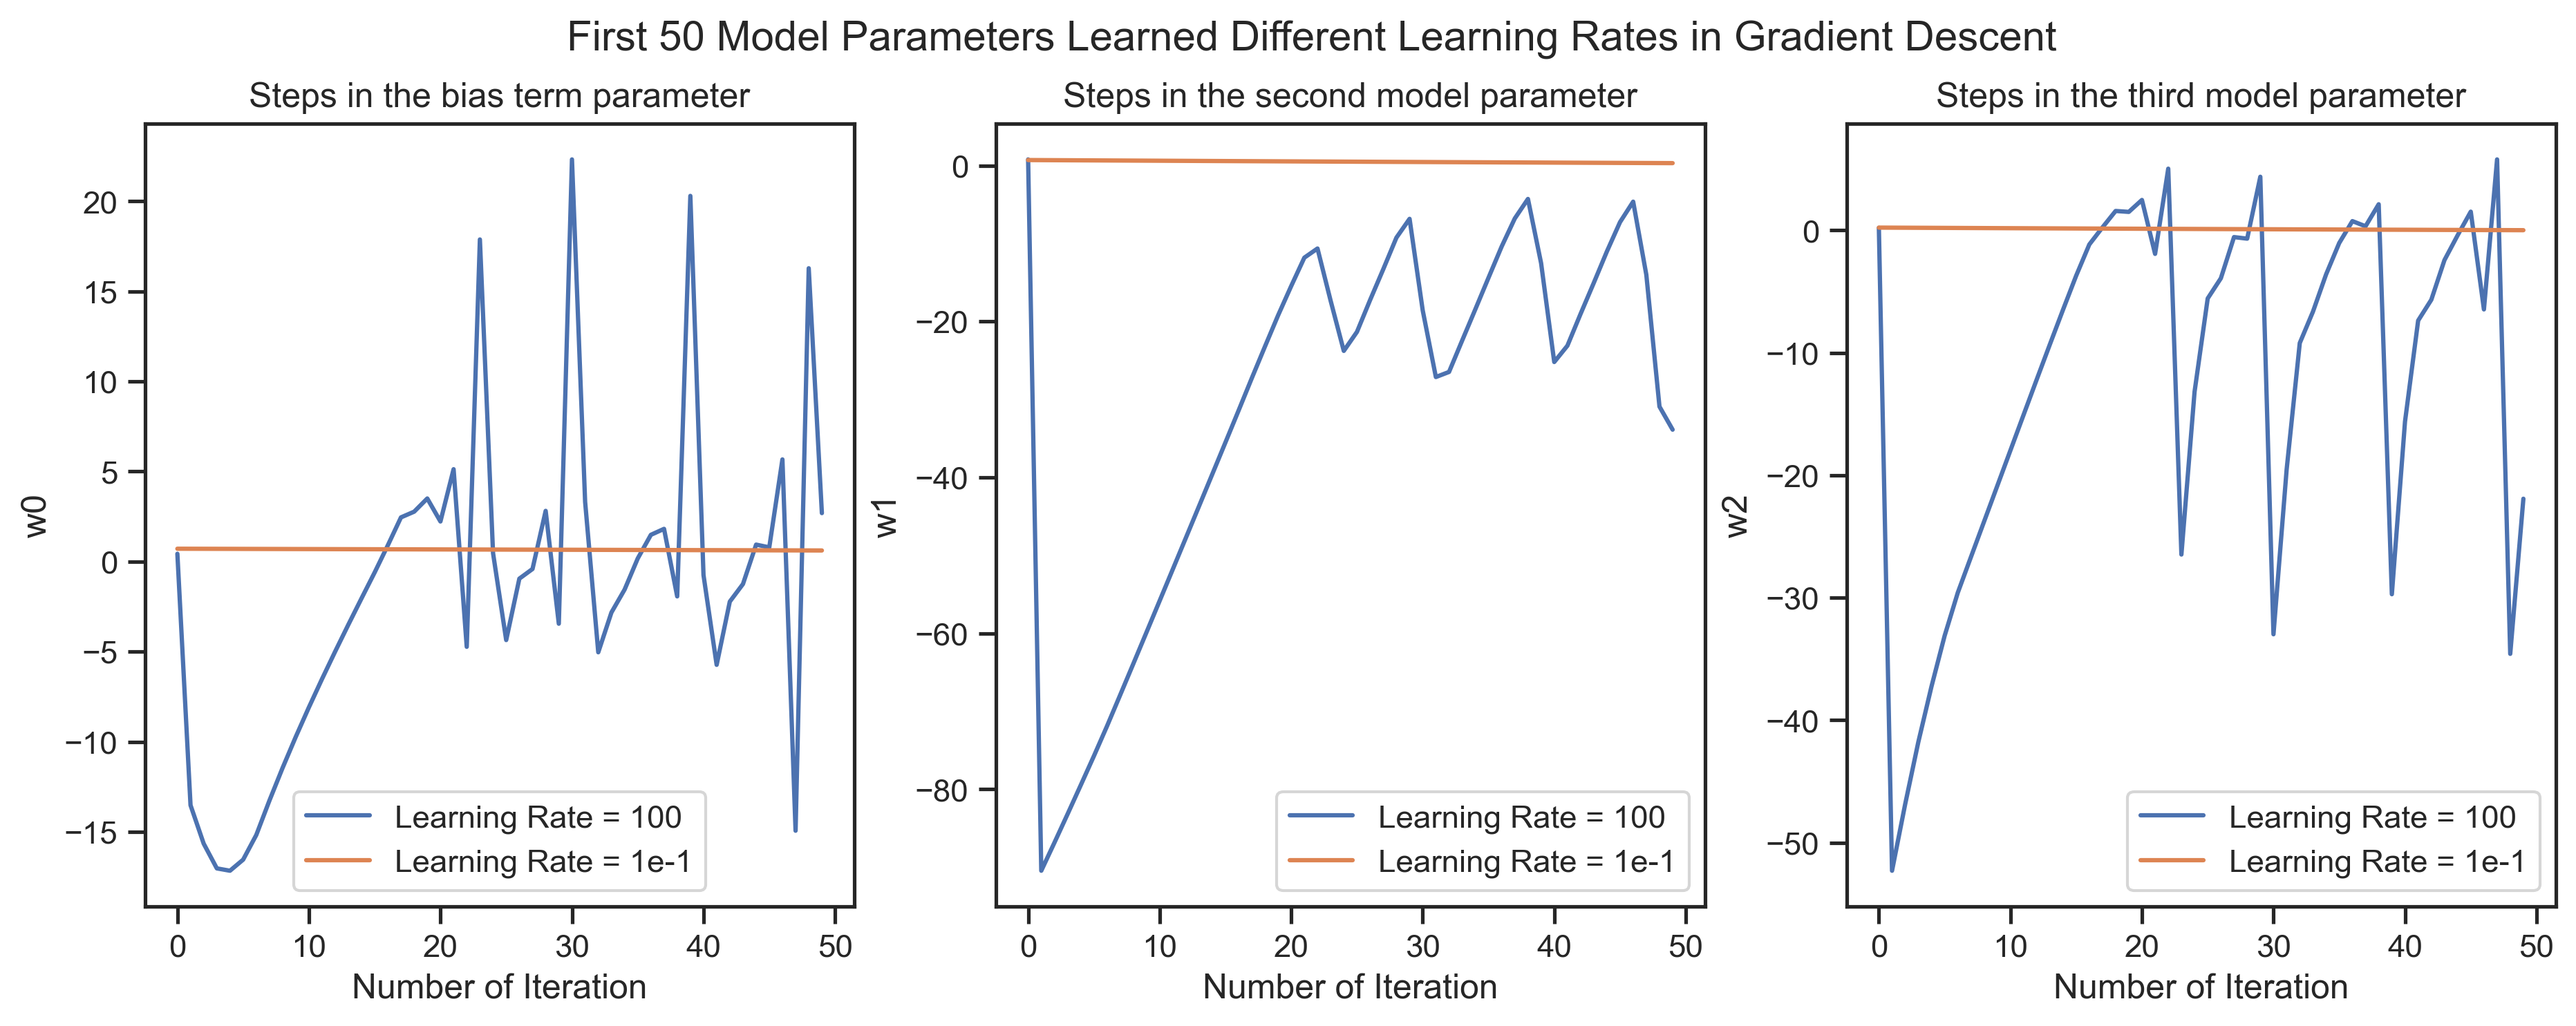

In [56]:
# Define a new logistic regression
regression_lr_3 = Logistic_regression()
# Fit the logistic regression on X data
regression_lr_3.fit(X_train, y_train, lr=1e2)
# Store the saved parameters from the regression with large lr
w_history = np.array(regression_lr_3.saved_w)
# Get the saved parameters from our best lr
w_history_lr_1 = np.array(regression_lr_1.saved_w)

# Plot the steps
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the first model parameter
axes[0].plot(w_history[0:50, 0], label="Learning Rate = 100")
axes[0].plot(w_history_lr_1[0:50, 0], label="Learning Rate = 1e-1")
axes[0].set_xlabel("Number of Iteration")
axes[0].set_ylabel("w0")
axes[0].set_title("Steps in the bias term parameter")
axes[0].legend()
axes[1].plot(w_history[0:50, 1], label="Learning Rate = 100")
axes[1].plot(w_history_lr_1[0:50, 1], label="Learning Rate = 1e-1")
axes[1].set_xlabel("Number of Iteration")
axes[1].set_ylabel("w1")
axes[1].set_title("Steps in the second model parameter")
axes[1].legend()
axes[2].plot(w_history[0:50, 2], label="Learning Rate = 100")
axes[2].plot(w_history_lr_1[0:50, 2], label="Learning Rate = 1e-1")
axes[2].set_xlabel("Number of Iteration")
axes[2].set_ylabel("w2")
axes[2].set_title("Steps in the third model parameter")
axes[2].legend()
fig.suptitle(
    "First 50 Model Parameters Learned Different" 
    " Learning Rates in Gradient Descent"
)
plt.show()


>In this plot of the first 50 weight vectors learned through different learning rates during gradient descent, we see that when learning rate is 100, the gradient descent algorithm have very large oscillations between each step. This is because the learning rate magnifies the gradient of each step and the algorithm has to go back and forth across the valley of the cost function convex. This is in contrast to the change in the weight vector when learning rate is 0.1. In this case, the algorithm moves in a stable fashion toward the minima of the cost function.
>
> After reviewing the two plots above, which shows the effects of learning rates on the speed of conversion and reduction in the cost function, we can see that too small of a learning rate leads to very slow conversion to the convex of the cost function. However, too high of a learning rate makes it so that each step of the gradient descent is too large to actually get to the local minimum and thus the algorithm bounces around the convex of the cost function, unable to find the optimal gradient. When the learning rate is either too small or too large, the speed of conversion will be slow. The most optimal learning rate should be somewhere in between. 
> 
>Therefore, we want to pick 0.1 as the learning rate for this problem because it's able to converge relatively fast and still obtain a good estimate of the critical point. 

### V. Evaluate your model performance through cross validation {-}

**(i)** Test the performance of your trained classifier using K-folds cross validation resampling technique. The scikit-learn package [StratifiedKFolds](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) may be helpful. 
- Train your logistic regression model and a K-Nearest Neighbor classification model with $k=7$ nearest neighbors.
- Using the trained models, make four plots: two for logistic regression and two for KNN. For each model have one plot showing the training data used for fitting the model, and the other showing the test data. On each plot, include the decision boundary resulting from your trained classifier.
- Produce a Receiver Operating Characteristic curve (ROC curve) that represents the performance from cross validated performance evaluation for each classifier (your logistic regression model and the KNN model, with $k=7$ nearest neighbors). For the cross validation, use $k=10$ folds. 
  - Plot these curves on the same set of axes to compare them
  - On the ROC curve plot, also include the chance diagonal for reference (this represents the performance of the worst possible classifier). This is represented as a line from $(0,0)$ to $(1,1)$.
  - Calculate the Area Under the Curve for each model and include this measure in the legend of the ROC plot.
- Comment on the following:
  - What is the purpose of using cross validation for this problem?
  - How do the models compare in terms of performance (both ROC curves and decision boundaries) and which model (logistic regression or KNN) would you select to use on previously unseen data for this problem and why?

**ANSWER**

##### (i) Fitting the models and plotting decision boundaries {-}

> We first train both the KNN model imported from sklearn and also the logistic regression model that we created ourselves. 

In [57]:
# Import knn sklearn module
from sklearn.neighbors import KNeighborsClassifier

# Fit the KNN model
knn_v = KNeighborsClassifier(n_neighbors=7)
knn_v.fit(X_train.values, y_train.values)
# Fit logistic regression model
logreg_v = Logistic_regression()
logreg_v.fit(X_train, y_train, lr=0.1)


> Here, we write a helpful function that will allow us to draw the decision boundaries and fill it into a 2x2 figure with 4 axes.

In [58]:
# Writing a helper function to draw decision boundaries
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(["cornflowerblue", "navajowhite"])
cmap_bold = ["midnightblue", "orange"]


def draw_decision_boundary(model, X, y, ax, xlabel, ylabel):
    """Draws decision boundary of a given model with X, y
    data, the axis to plot the graph on, as well as xlabel
    and ylabel for the plot"""
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X["x1"].min(), X["x1"].max(), num=500),
        np.linspace(X["x2"].min(), X["x2"].max(), num=500),
    )

    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    y_pred = np.reshape(model.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(
        xx0=feature_1,
         xx1=feature_2, 
         response=y_pred)
    display.plot(ax=ax, xlabel=xlabel, ylabel=ylabel, cmap=cmap_light)
    sns.scatterplot(
        x=X["x1"],
        y=X["x2"],
        hue=y,
        ax=ax,
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )


> Using the helpful function above, we can draw the decision boundaries and plot the data points in both our training set and our test set, for the KNN model and the logistic regression models. 

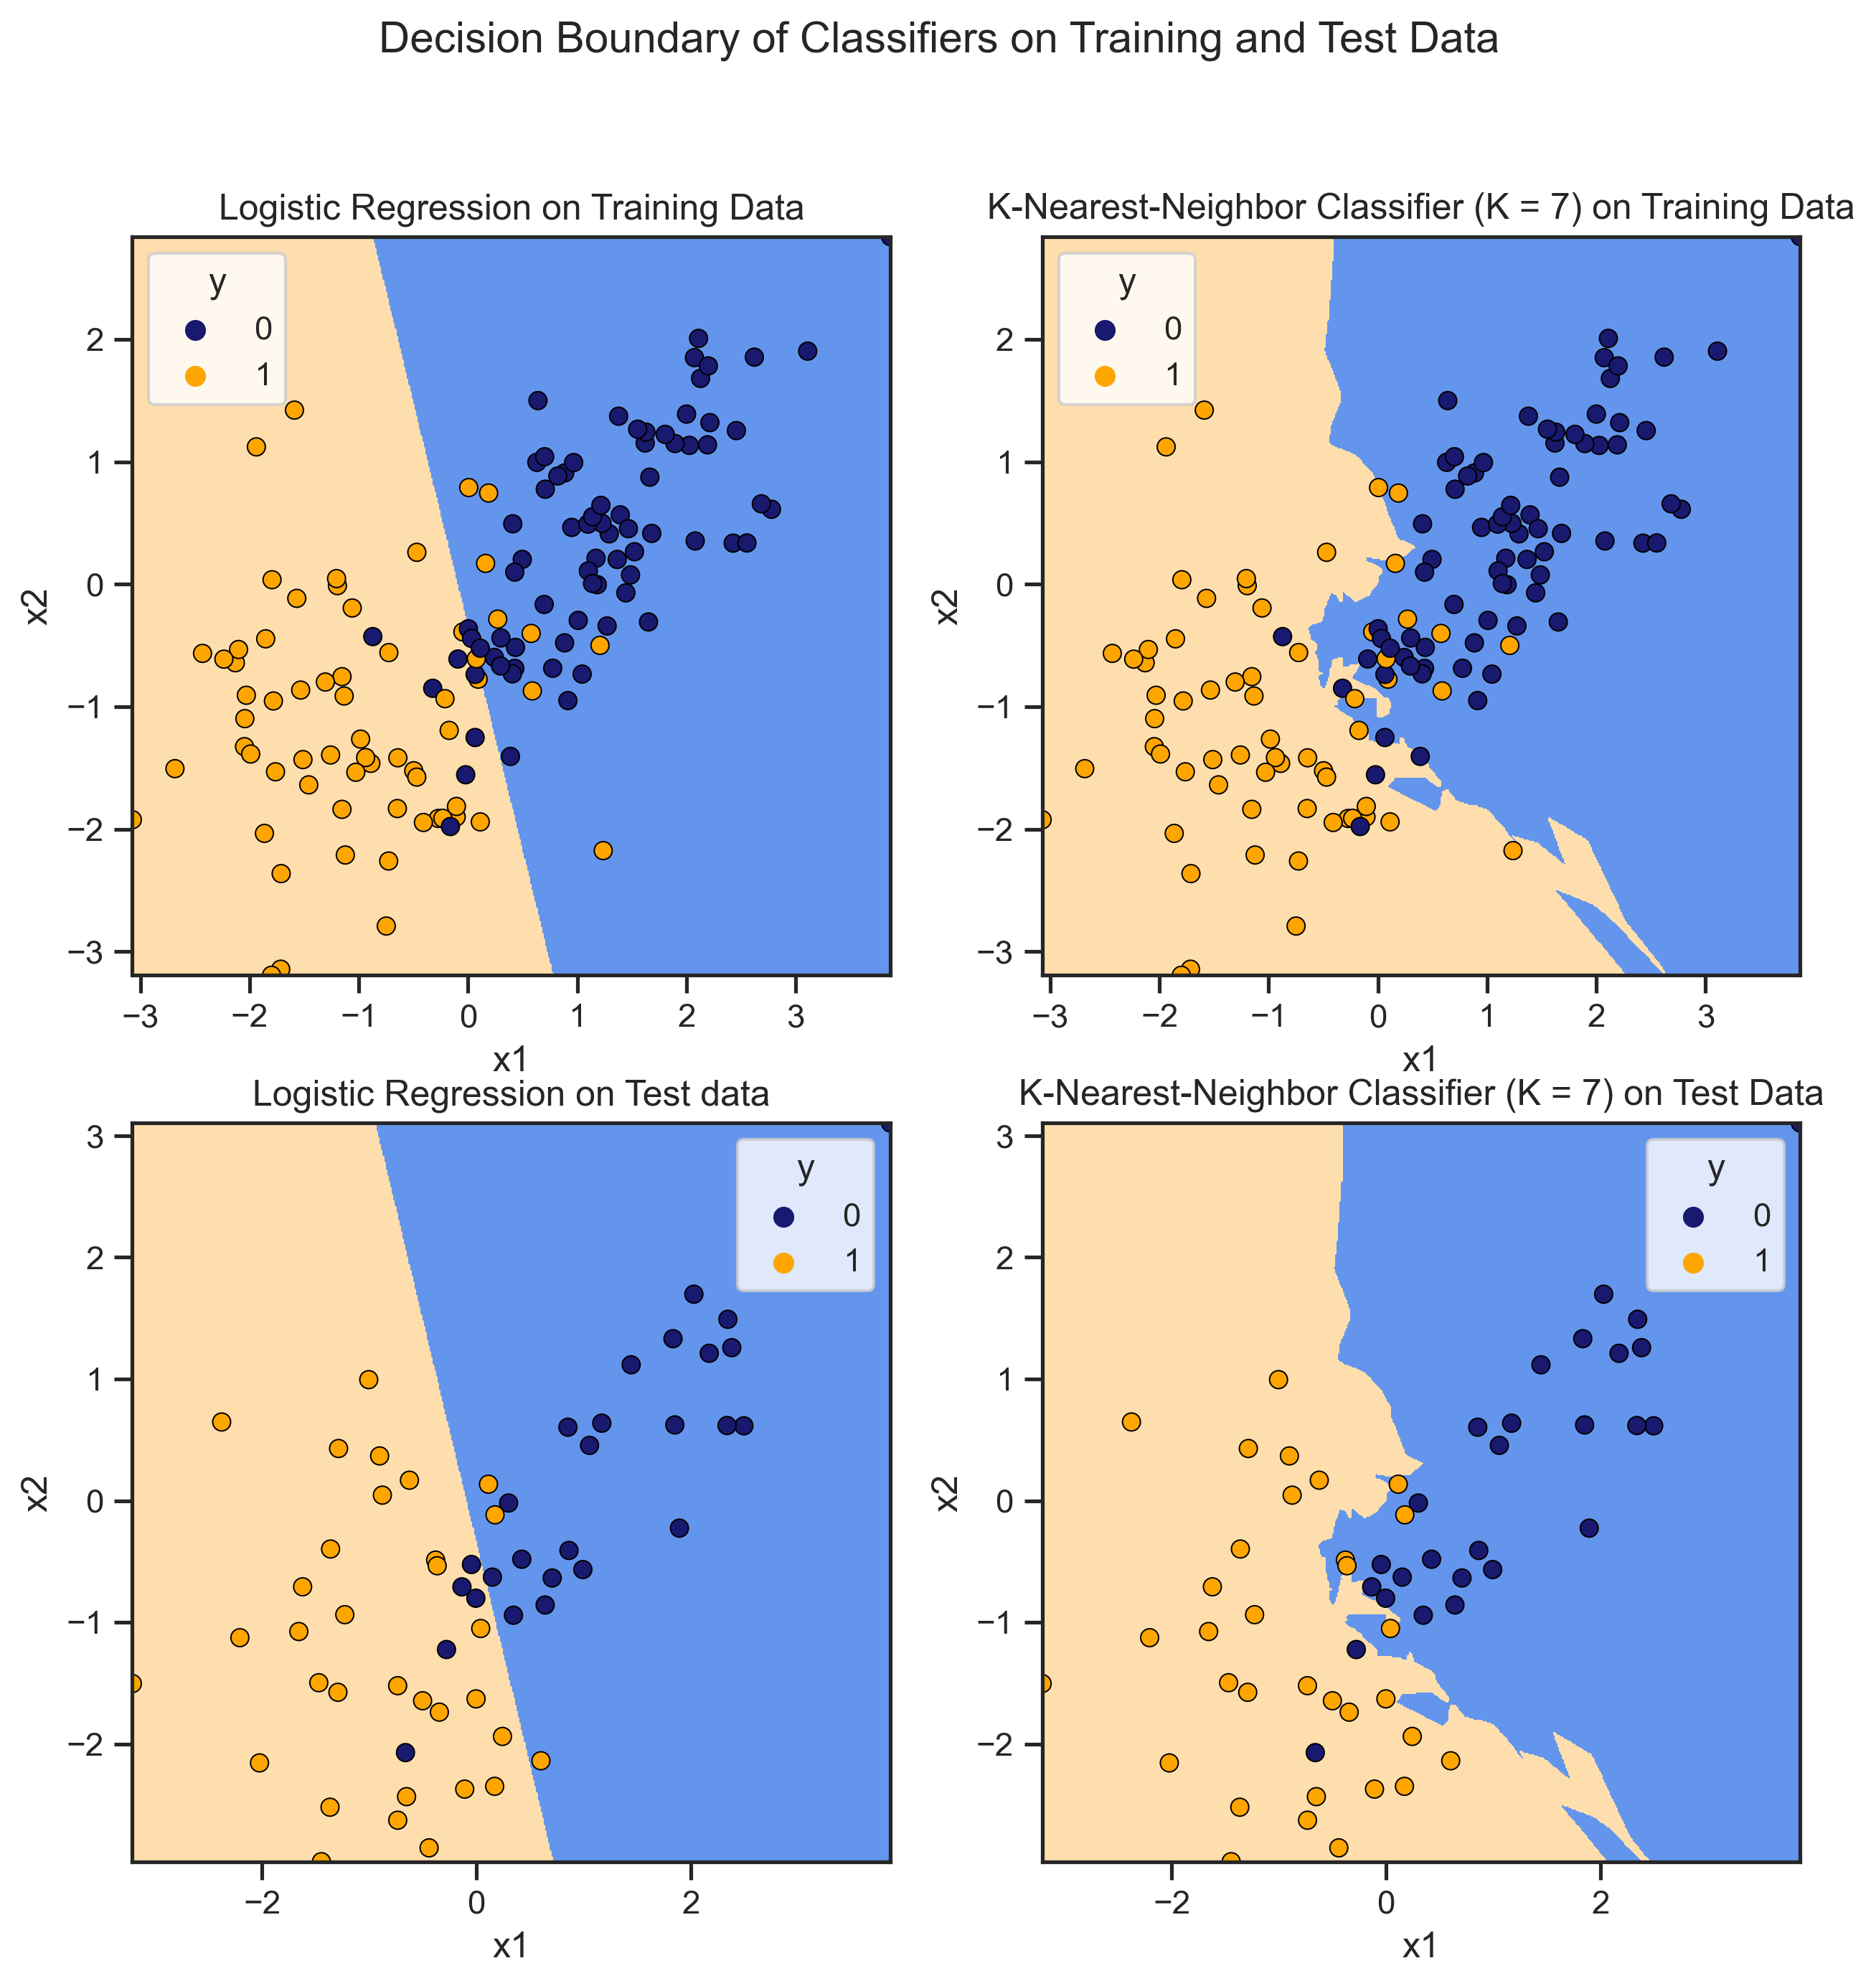

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
draw_decision_boundary(
    logreg_v, X_train, y_train, ax=axes[0, 0], xlabel="x1", ylabel="x2"
)
draw_decision_boundary(
    logreg_v, X_test, y_test, ax=axes[1, 0], xlabel="x1", ylabel="x2"
)
draw_decision_boundary(knn_v, X_train, y_train, 
                    ax=axes[0, 1], xlabel="x1", ylabel="x2")
draw_decision_boundary(knn_v, X_test, y_test, 
                    ax=axes[1, 1], xlabel="x1", ylabel="x2")
axes[0, 0].set_title("Logistic Regression on Training Data")
axes[1, 0].set_title("Logistic Regression on Test data")
axes[0, 1].set_title("K-Nearest-Neighbor Classifier (K = 7) on Training Data")
axes[1, 1].set_title("K-Nearest-Neighbor Classifier (K = 7) on Test Data")
fig.suptitle("Decision Boundary of Classifiers on Training and Test Data")
plt.show()


> We can see in the plot above that the logistic regression decision boundaries are linear, and the KNN decision boundaries are non-linear. This works for our data because there is an approximate linear boundary between the two classes.

##### Plotting the Receiving Operating Curve {-}

> Before we can plot the ROC curve, we must first separate the data into K folds for the cross validation process.

In [60]:
# Import stratified k folds
from sklearn.model_selection import StratifiedKFold

# Split data into 10 folds
skf = StratifiedKFold(n_splits=10)
# Get the full dataset
X = q1_data[["x1", "x2"]]
y = q1_data["y"]


> We iterate over the 10 folds to fit the logistic regression and the KNN classifier 10 different times. Each time making predictions and writing down the confidence scores of the observations in the test set. We then concatenate all these prediction probabilities together into a single array for our y predictions. Referencing this array, we can calculate the True Positive and False Positive rates of each chosen threshold and then construct the ROC curve.

In [61]:
# create an empty array for predicted probabilities for each observation
logistic_probs = np.empty(0)
logistic_true_y = np.empty(0)
knn_probs = np.empty(0)
knn_true_y = np.empty(0)

# Iterate over each fold and calculate the test probabilities
for (train_index, test_index) in skf.split(X, y):
    # Split our data by the train and test indices
    X_train_fold = X.loc[train_index]
    y_train_fold = y.loc[train_index]
    X_test_fold = X.loc[test_index]
    y_test_fold = y.loc[test_index]
    # train the logistic gregression
    log_reg_fold = Logistic_regression()
    log_reg_fold.fit(X_train_fold, y_train_fold, lr=1)
    # Get the predicted probabilities of the X test data
    log_probs_fold = log_reg_fold.predict_proba(X_test_fold)
    # Append the predicted probabilities
    logistic_probs = np.append(logistic_probs, log_probs_fold)
    # Append the actual ys
    logistic_true_y = np.append(logistic_true_y, y_test_fold)
    # Train the knn model
    knn_fold = KNeighborsClassifier(n_neighbors=7).fit(
        X_train_fold, y_train_fold)
    # Get the predicted probabilities of the X test data
    knn_probs_fold = knn_fold.predict_proba(X_test_fold)
    # Append the predicted probabilities
    knn_probs = np.append(knn_probs, knn_probs_fold[:, 1])
    # Append the actual ys
    knn_true_y = np.append(knn_true_y, y_test_fold)


> Using the False Positive Rate, True Positive Rate we generated from each model, we can plot the ROC curve of the Logistic Regression and the KNN.

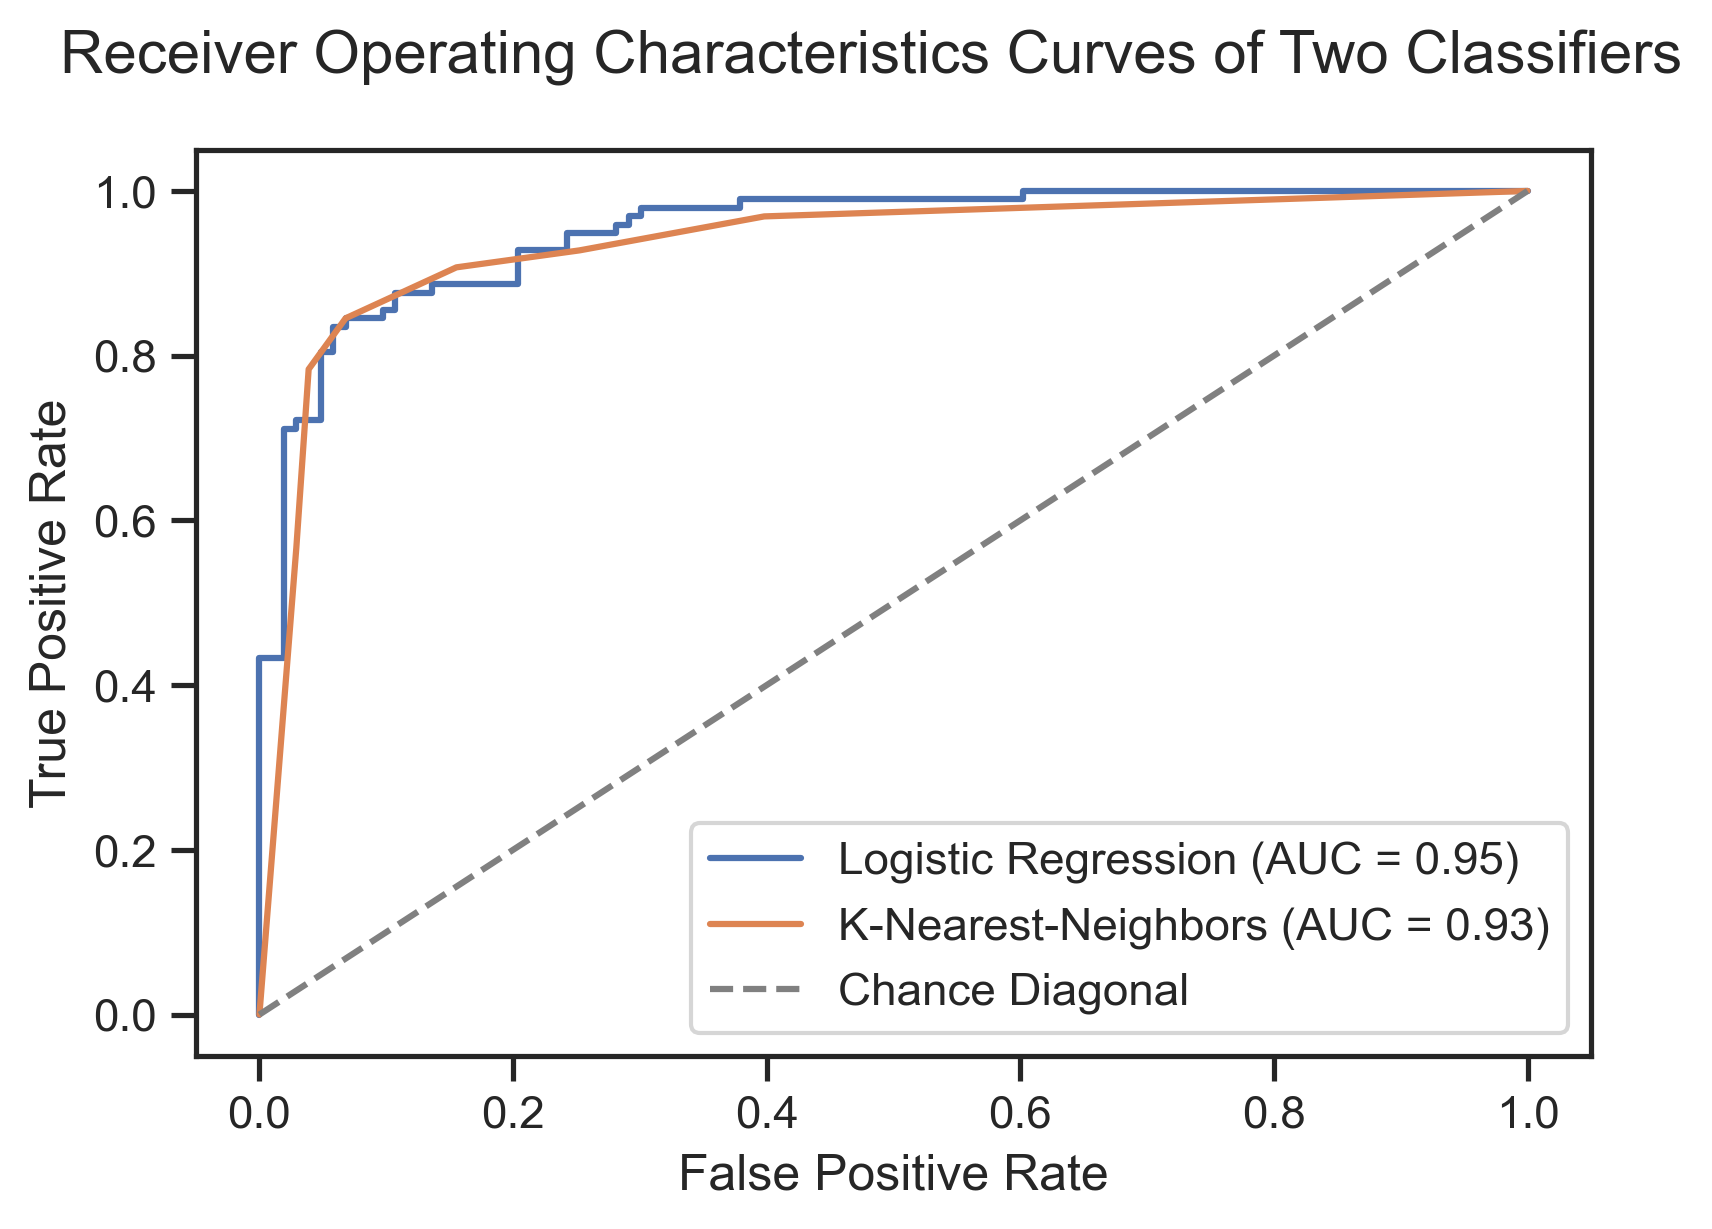

In [62]:
from sklearn.metrics import RocCurveDisplay

# Create chance diagonal
chance = np.stack((np.linspace(0, 1, 500), np.linspace(0, 1, 500)), axis=1)

fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    y_true=logistic_true_y, y_pred=logistic_probs, 
    ax=ax, name="Logistic Regression"
)
RocCurveDisplay.from_predictions(
    y_true=knn_true_y, y_pred=knn_probs, 
    ax=ax, name="K-Nearest-Neighbors"
)
ax.plot(
    chance[:, 0], chance[:, 1], linestyle="dashed", 
    c="gray", label="Chance Diagonal"
)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
fig.suptitle("Receiver Operating Characteristics Curves of Two Classifiers")
plt.show()


> The purpose of using cross validation for this problem is to both conduct performance evaluation – getting an unbiased estimate of how well the model performs on unseen data, as well as to compare the logistic.
>
> Both estimators perform similarly well in cross-validation, they both have AUCs of over 90%. The choice of either one of these estimators depends on the priorities of the decision-maker. If overall accuracy is important, we may want to pick the KNN model because it looks like it is the curve that is higher at the top-left corner. However, if true positive rate matters more, in instances such as spam detection or land-mind detection, then we should pick the logistic regression model because it has higher true positive rates for a slightly higher false positive rate. Additionally, referencing the decision boundaries plotted in the section above, we may choose the linear regression model if we have reasons to believe that the relationship between the features and the response is linear, and use the KNN model if the relationship is more non-linear.

# 2 {-}

## Digits classification {-}
**[30 points]**

*An exploration of regularization, imbalanced classes, ROC and PR curves*

The goal of this exercise is to apply your supervised learning skills on a very different dataset: in this case, image data; MNIST: a collection of images of handwritten digits. Your goal is to train a classifier that is able to distinguish the number "3" from all possible numbers and to do so as accurately as possible. You will first explore your data (this should always be your starting point to gain domain knowledge about the problem.). Since the feature space in this problem is 784-dimensional, overfitting is possible. To avoid overfitting you will investigate the impact of regularization on generalization performance (test accuracy) and compare regularized and unregularized logistic regression model test error against other classification techniques such as linear discriminant analysis and random forests and draw conclusions about the best-performing model.

Start by loading your dataset from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits, using the code provided below. MNIST has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

Your goal is to classify whether or not an example digit is a 3. Your binary classifier should predict $y=1$ if the digit is a 3, and $y=0$ otherwise. Create your dataset by transforming your labels into a binary format (3's are class 1, and all other digits are class 0). 


**(a)** Plot 10 examples of each class (i.e. class $y=0$, which are not 3's and class $y=1$ which are 3's), from the training dataset.
- Note that the data are composed of samples of length 784. These represent 28 x 28 images, but have been reshaped for storage convenience. To plot digit examples, you'll need to reshape the data to be 28 x 28 (which can be done with numpy `reshape`).

**(b)** How many examples are present in each class? Show a plot of samples by class (bar plot). What fraction of samples are positive? What issues might this cause?

**(c)** Identify the value of the regularization parameter that optimizes model performance on out-of-sample data. Using a logistic regression classifier, apply lasso regularization and retrain the model and evaluate its performance on the test set over a range of values on the regularization coefficient. You can implement this using the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module and activating the 'l1' penalty; the parameter $C$ is the inverse of the regularization strength. Vary the value of C logarithmically from $10^{-4}$ to $10^4$ (and make your x-axes logarithmic in scale) and evaluate it at least 20 different values of C. As you vary the regularization coefficient, Plot the following four quantities (this should result in 4 separate plots)... 
- The number of model parameters that are estimated to be nonzero (in the logistic regression model, one attribute is `coef_`, which gives you access to the model parameters for a trained model)
- The cross entropy loss (which can be evaluated with the Scikit Learn `log_loss` function)
- Area under the ROC curve (AUC)
- The $F_1$-score (assuming a threshold of 0.5 on the predicted confidence scores, that is, scores above 0.5 are predicted as Class 1, otherwise Class 0). Scikit Learn also has a `f1_score` function which may be useful.
-Which value of C seems best for this problem? Please select the closest power of 10. You will use this in the next part of this exercise.

**(d)** Train and test a (1) logistic regression classifier with minimal regularization (using the Scikit Learn package, set penalty='l1', C=1e100 to approximate this), (2) a logistic regression classifier with the best value of the regularization parameter from the last section, (3) a Linear Discriminant Analysis (LDA) Classifier, and (4) a Random Forest (RF) classifier (using default parameters for the LDA and RF classifiers). 
- Compare your classifiers' performance using ROC and Precision Recall (PR) curves. For the ROC curves, all your curves should be plotted on the same set of axes so that you can directly compare them. Please do the same wih the PR curves.
- Plot the line that represents randomly guessing the class (50% of the time a "3", 50% not a "3"). You SHOULD NOT actually create random guesses. Instead, you should think through the theory behind how ROC and PR curves work and plot the appropriate lines. It's a good practice to include these in ROC and PR curve plots as a reference point.
- For PR curves, an excellent resource on how to correctly plot them can be found [here](https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/) (ignore the section on "non-linear interpolation between two points"). This describes how a random classifier is represented in PR curves and demonstrates that it should provide a lower bound on performance.
- When training your logistic regression model, it's recommended that you use solver="liblinear"; otherwise, your results may not converge.
- Describe the performance of the classifiers you compared. Did the regularization of the logistic regression model make much difference here? Which classifier you would select for application to unseen data.

In [63]:
# Load the MNIST Data
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Set this to True to download the data for the first 
#  time and False after the first time
#   so that you just load the data locally instead
download_data = False

if download_data:
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=False)

    # Adjust the labels to be '1' if y==3, and '0' otherwise
    y[y != "3"] = 0
    y[y == "3"] = 1
    y = y.astype("int")

    # Divide the data into a training and test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=1 / 7, random_state=88
    )

    file = open("tmpdata", "wb")
    pickle.dump((X_train, X_test, y_train, y_test), file)
    file.close()
else:
    file = open("tmpdata", "rb")
    X_train, X_test, y_train, y_test = pickle.load(file)
    file.close()


**Answer**

##### (a) Plot 10 examples in each class from the training dataset {-}

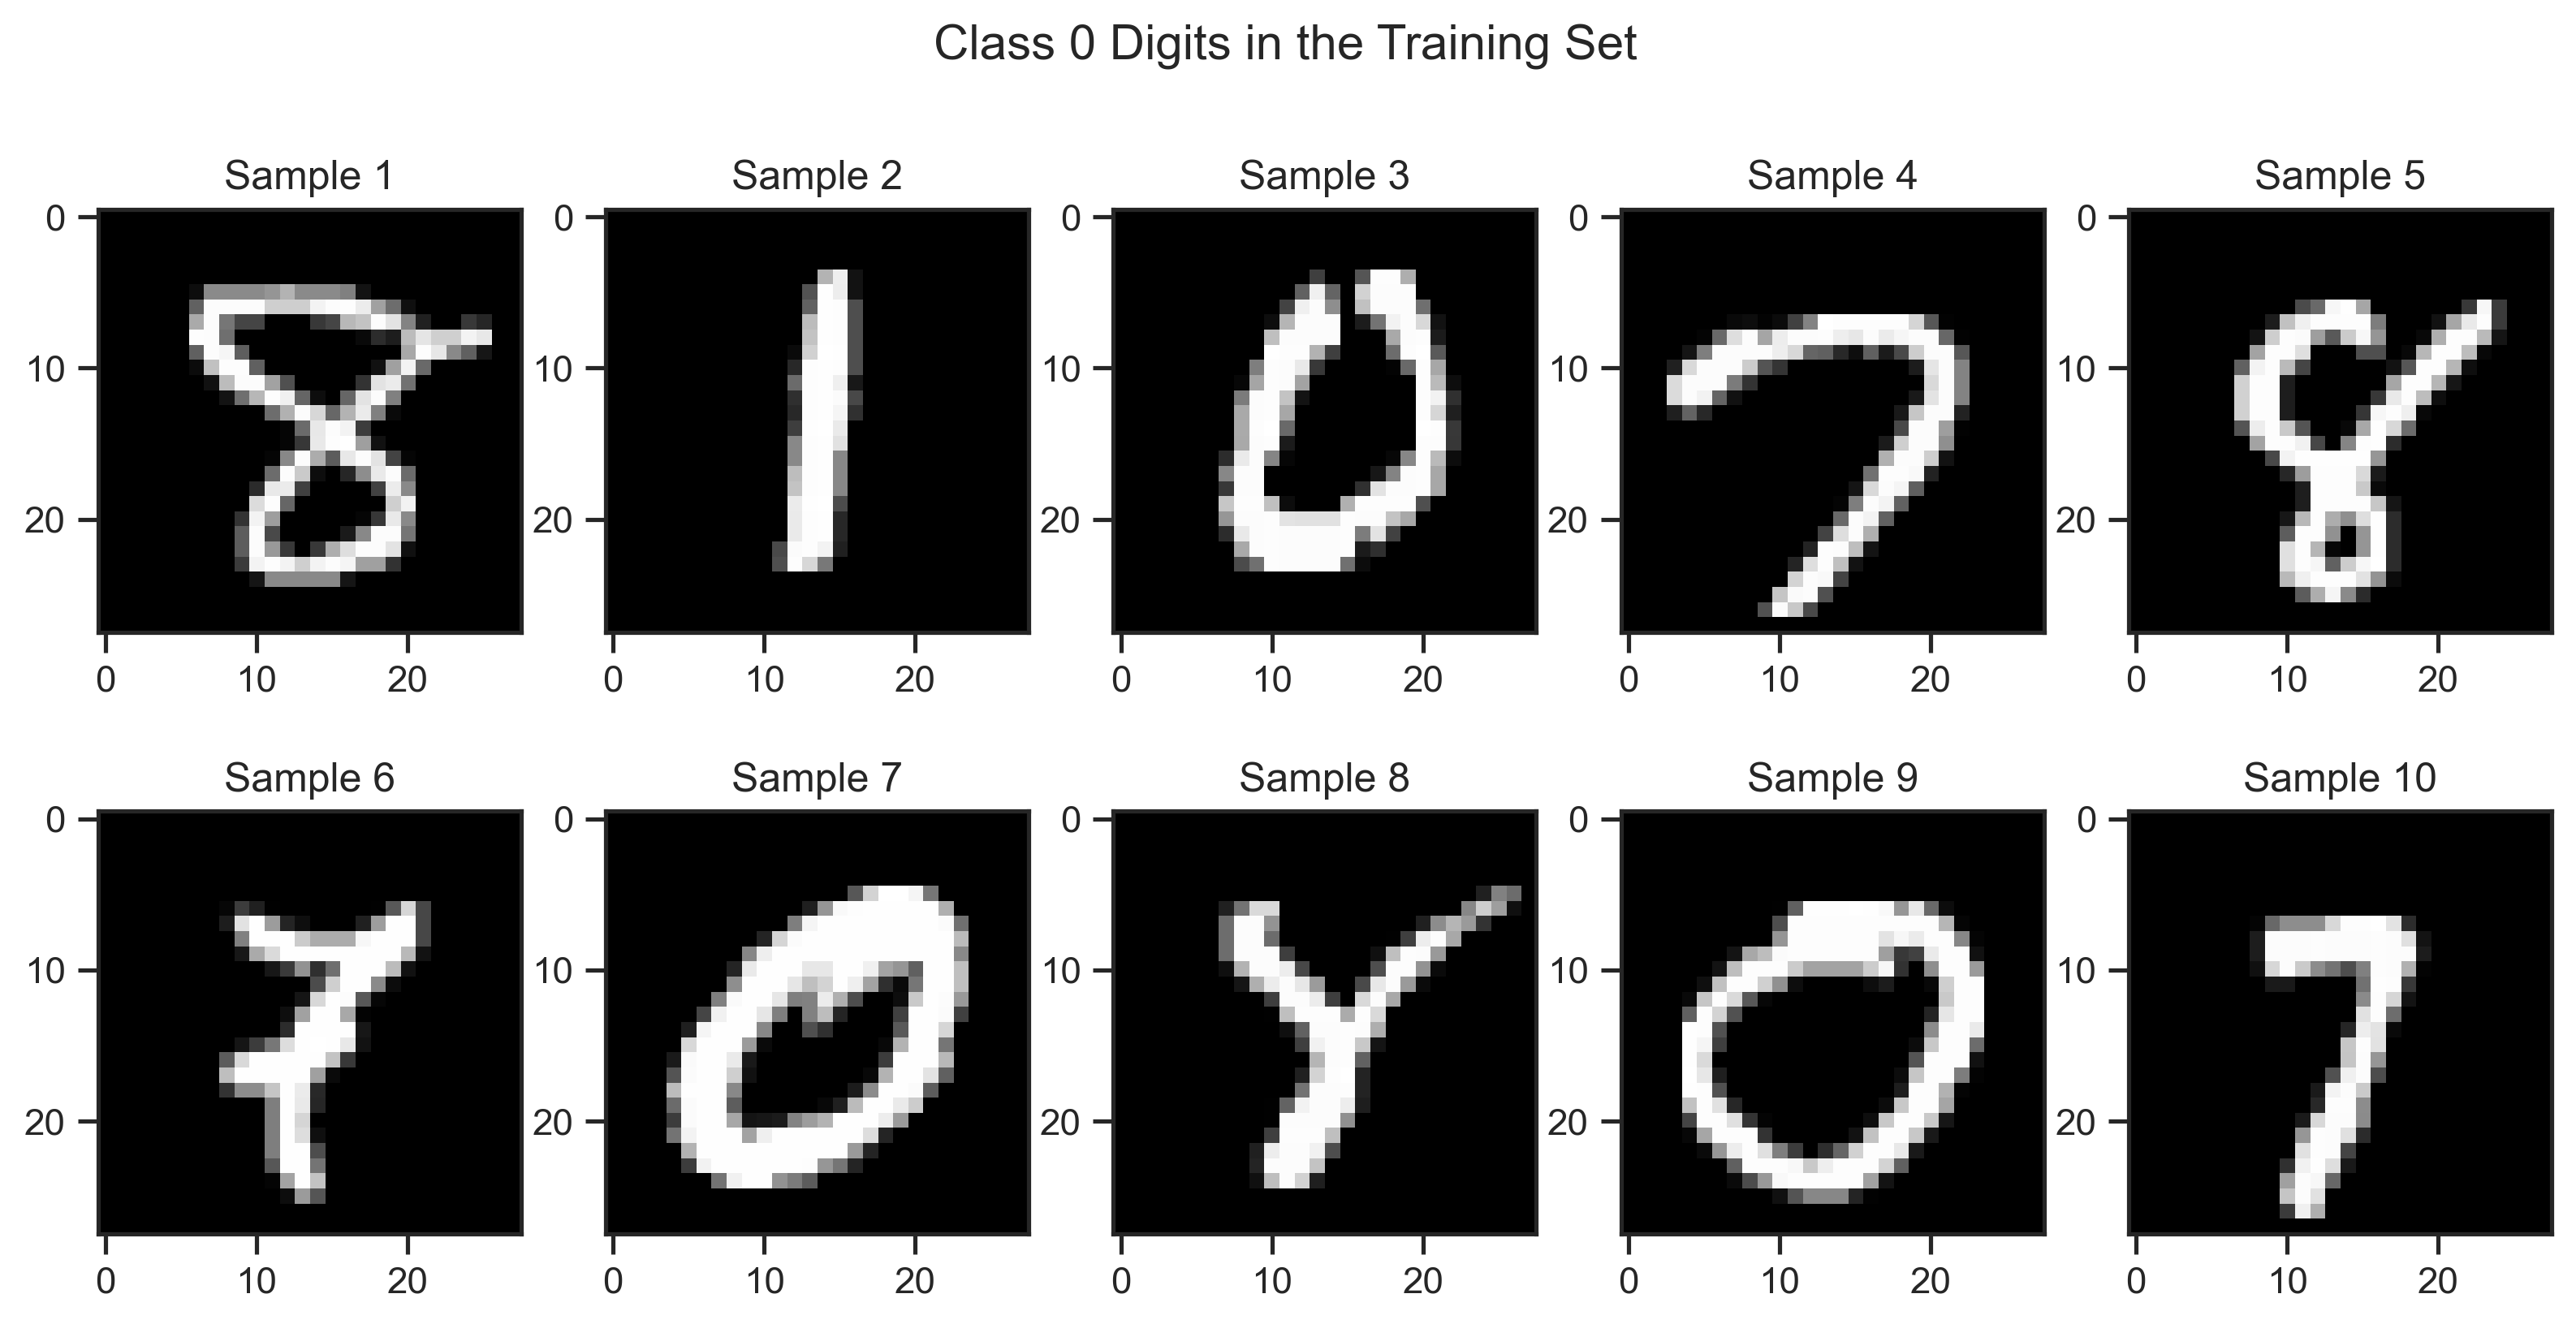

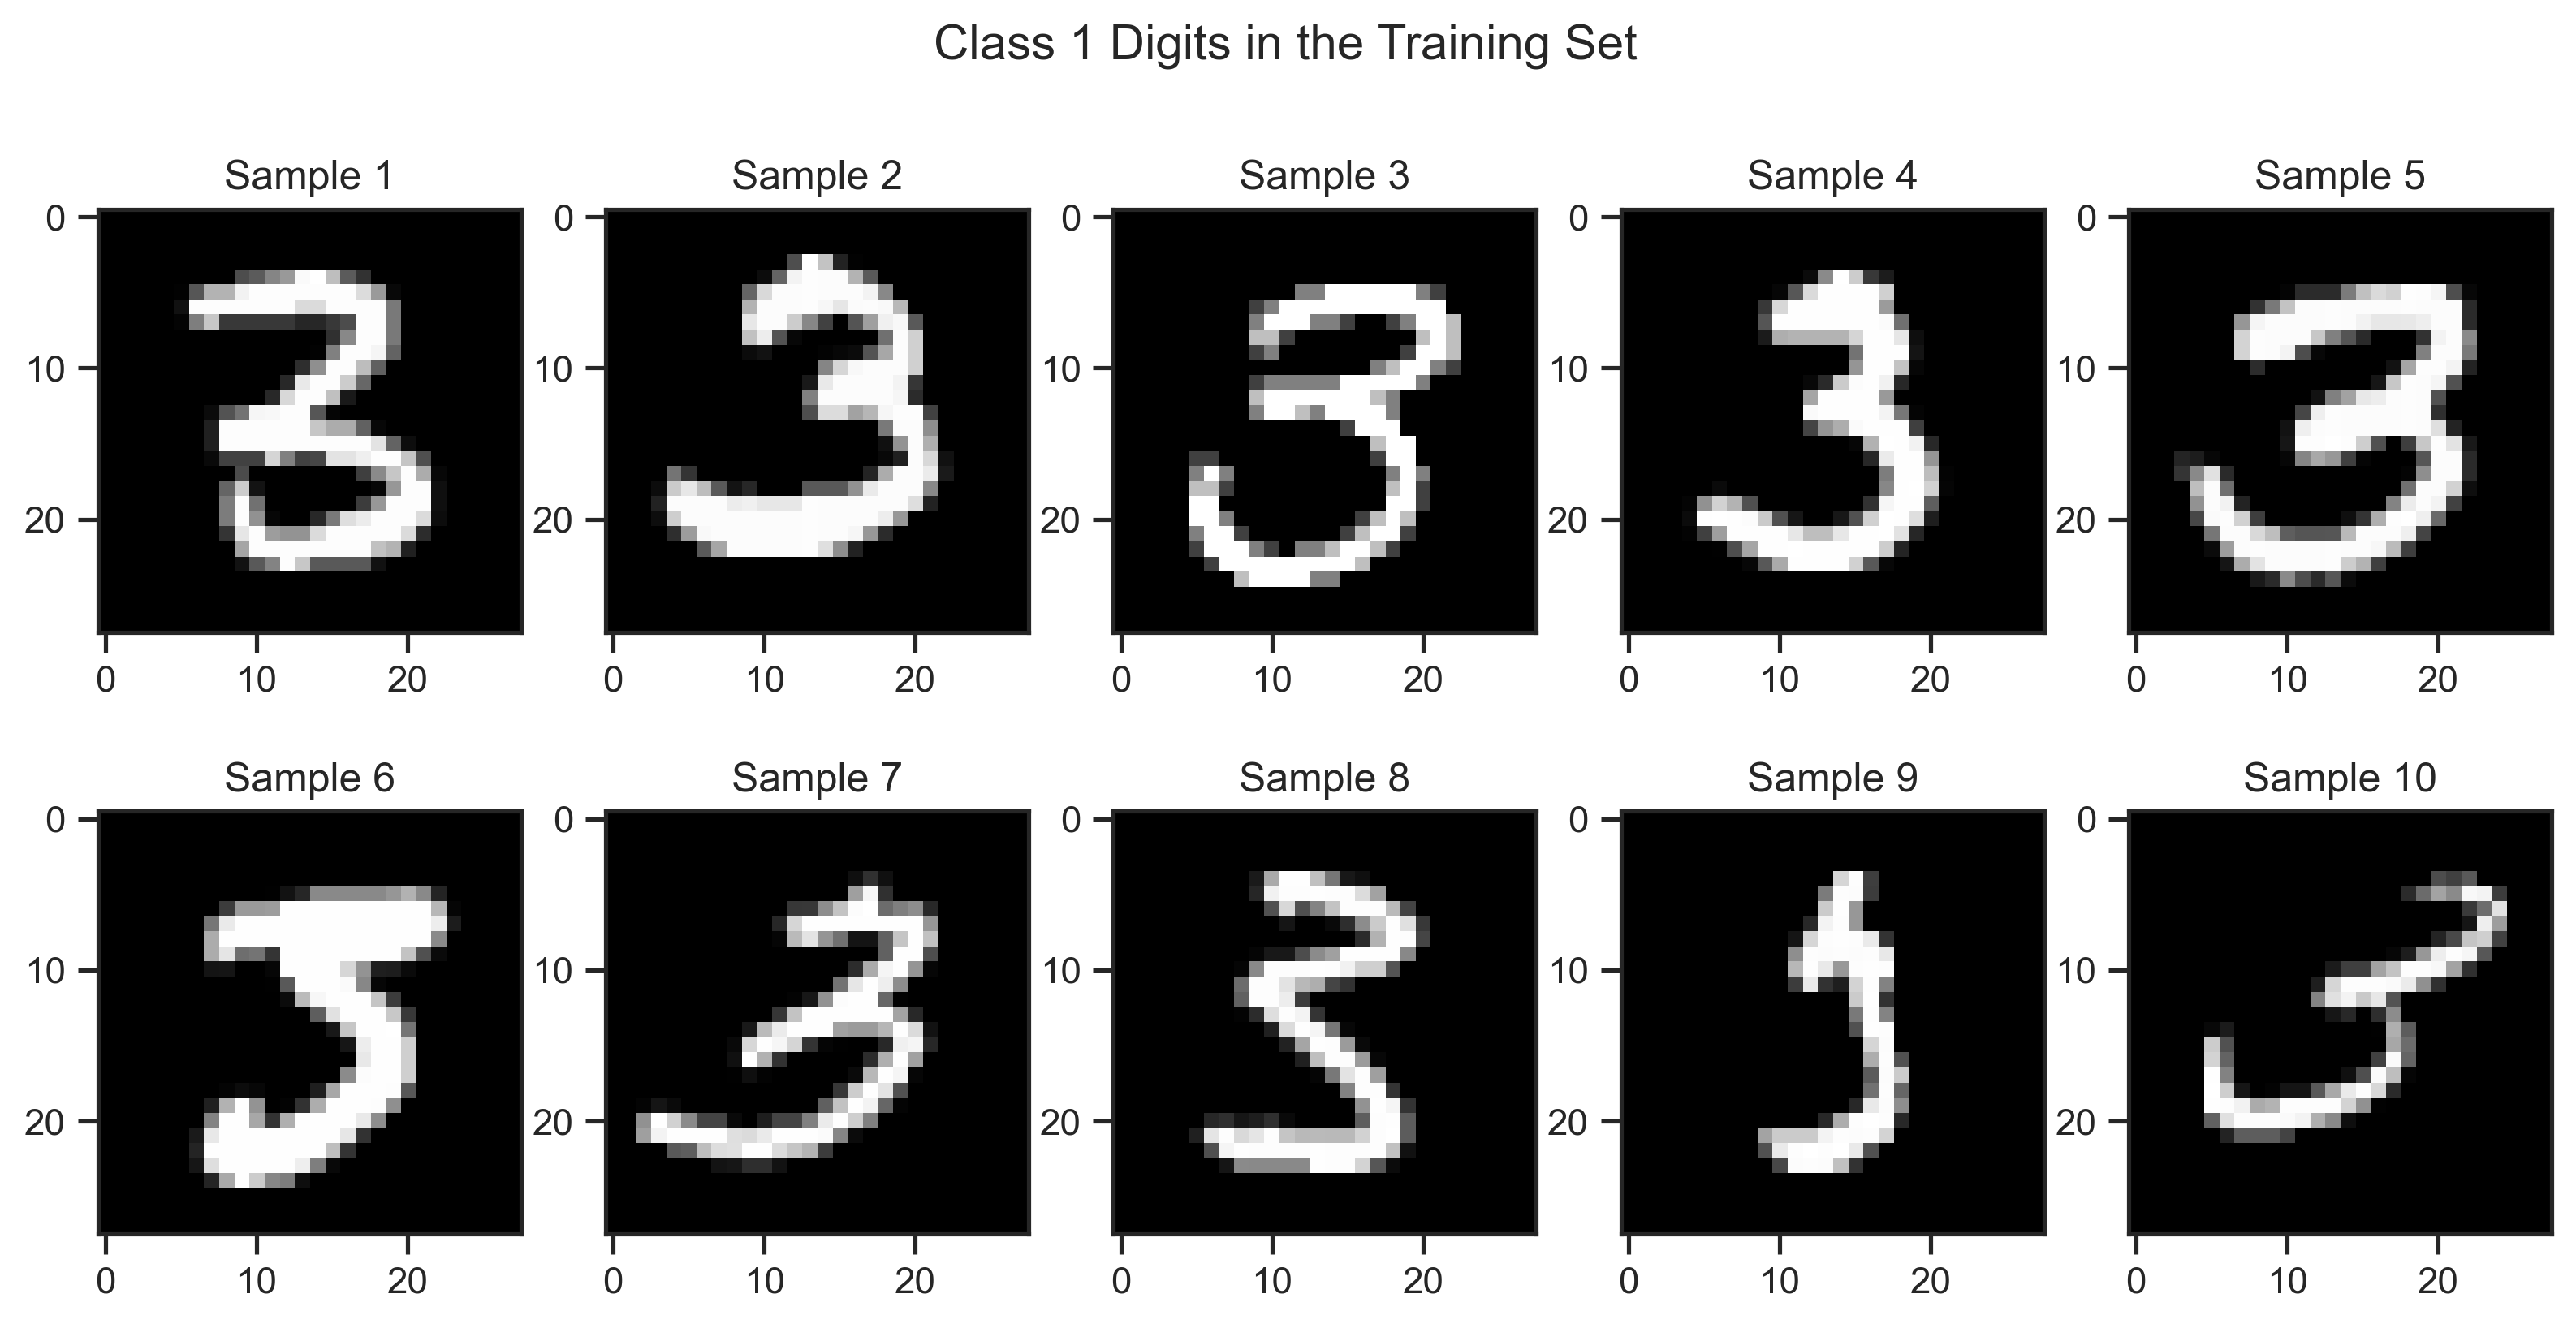

In [64]:
# Reshape X to get 28 x 28 images
X_reshaped = X_train.reshape((-1, 28, 28))
# retrieve 10 points where y = 0
X_0 = X_reshaped[y_train == 0][:10]
X_1 = X_reshaped[y_train == 1][:10]
fig, axes = plt.subplots(2, 5, figsize=(13, 6))
for i, sample in enumerate(X_0):
    row = i // 5
    column = i % 5
    axes[row, column].imshow(sample, cmap="gray")
    axes[row, column].set_title("Sample %i" % (i + 1))
fig.suptitle("Class 0 Digits in the Training Set")
plt.show()
# plot 10 points where y = 1
fig, axes = plt.subplots(2, 5, figsize=(13, 6))
for i, sample in enumerate(X_1):
    row = i // 5
    column = i % 5
    axes[row, column].imshow(sample, cmap="gray")
    axes[row, column].set_title("Sample %i" % (i + 1))
fig.suptitle("Class 1 Digits in the Training Set")
plt.show()


##### (b) Sample Imbalance {-}

In [65]:
# Print the number of samples in each class
print(f"There are a total of  {y_train.sum()} samples"
        f" of class 1 in the training set and {y_test.sum()}"
        f" in the test set")
print(f"There are a total of {len(y_train) - y_train.sum()}"
        f" samples of class 0 in the training set and "
        f"{len(y_test) - y_test.sum()}"
        f" in the test set")

There are a total of  6129 samples of class 1 in the training set and 1012 in the test set
There are a total of 53871 samples of class 0 in the training set and 8988 in the test set


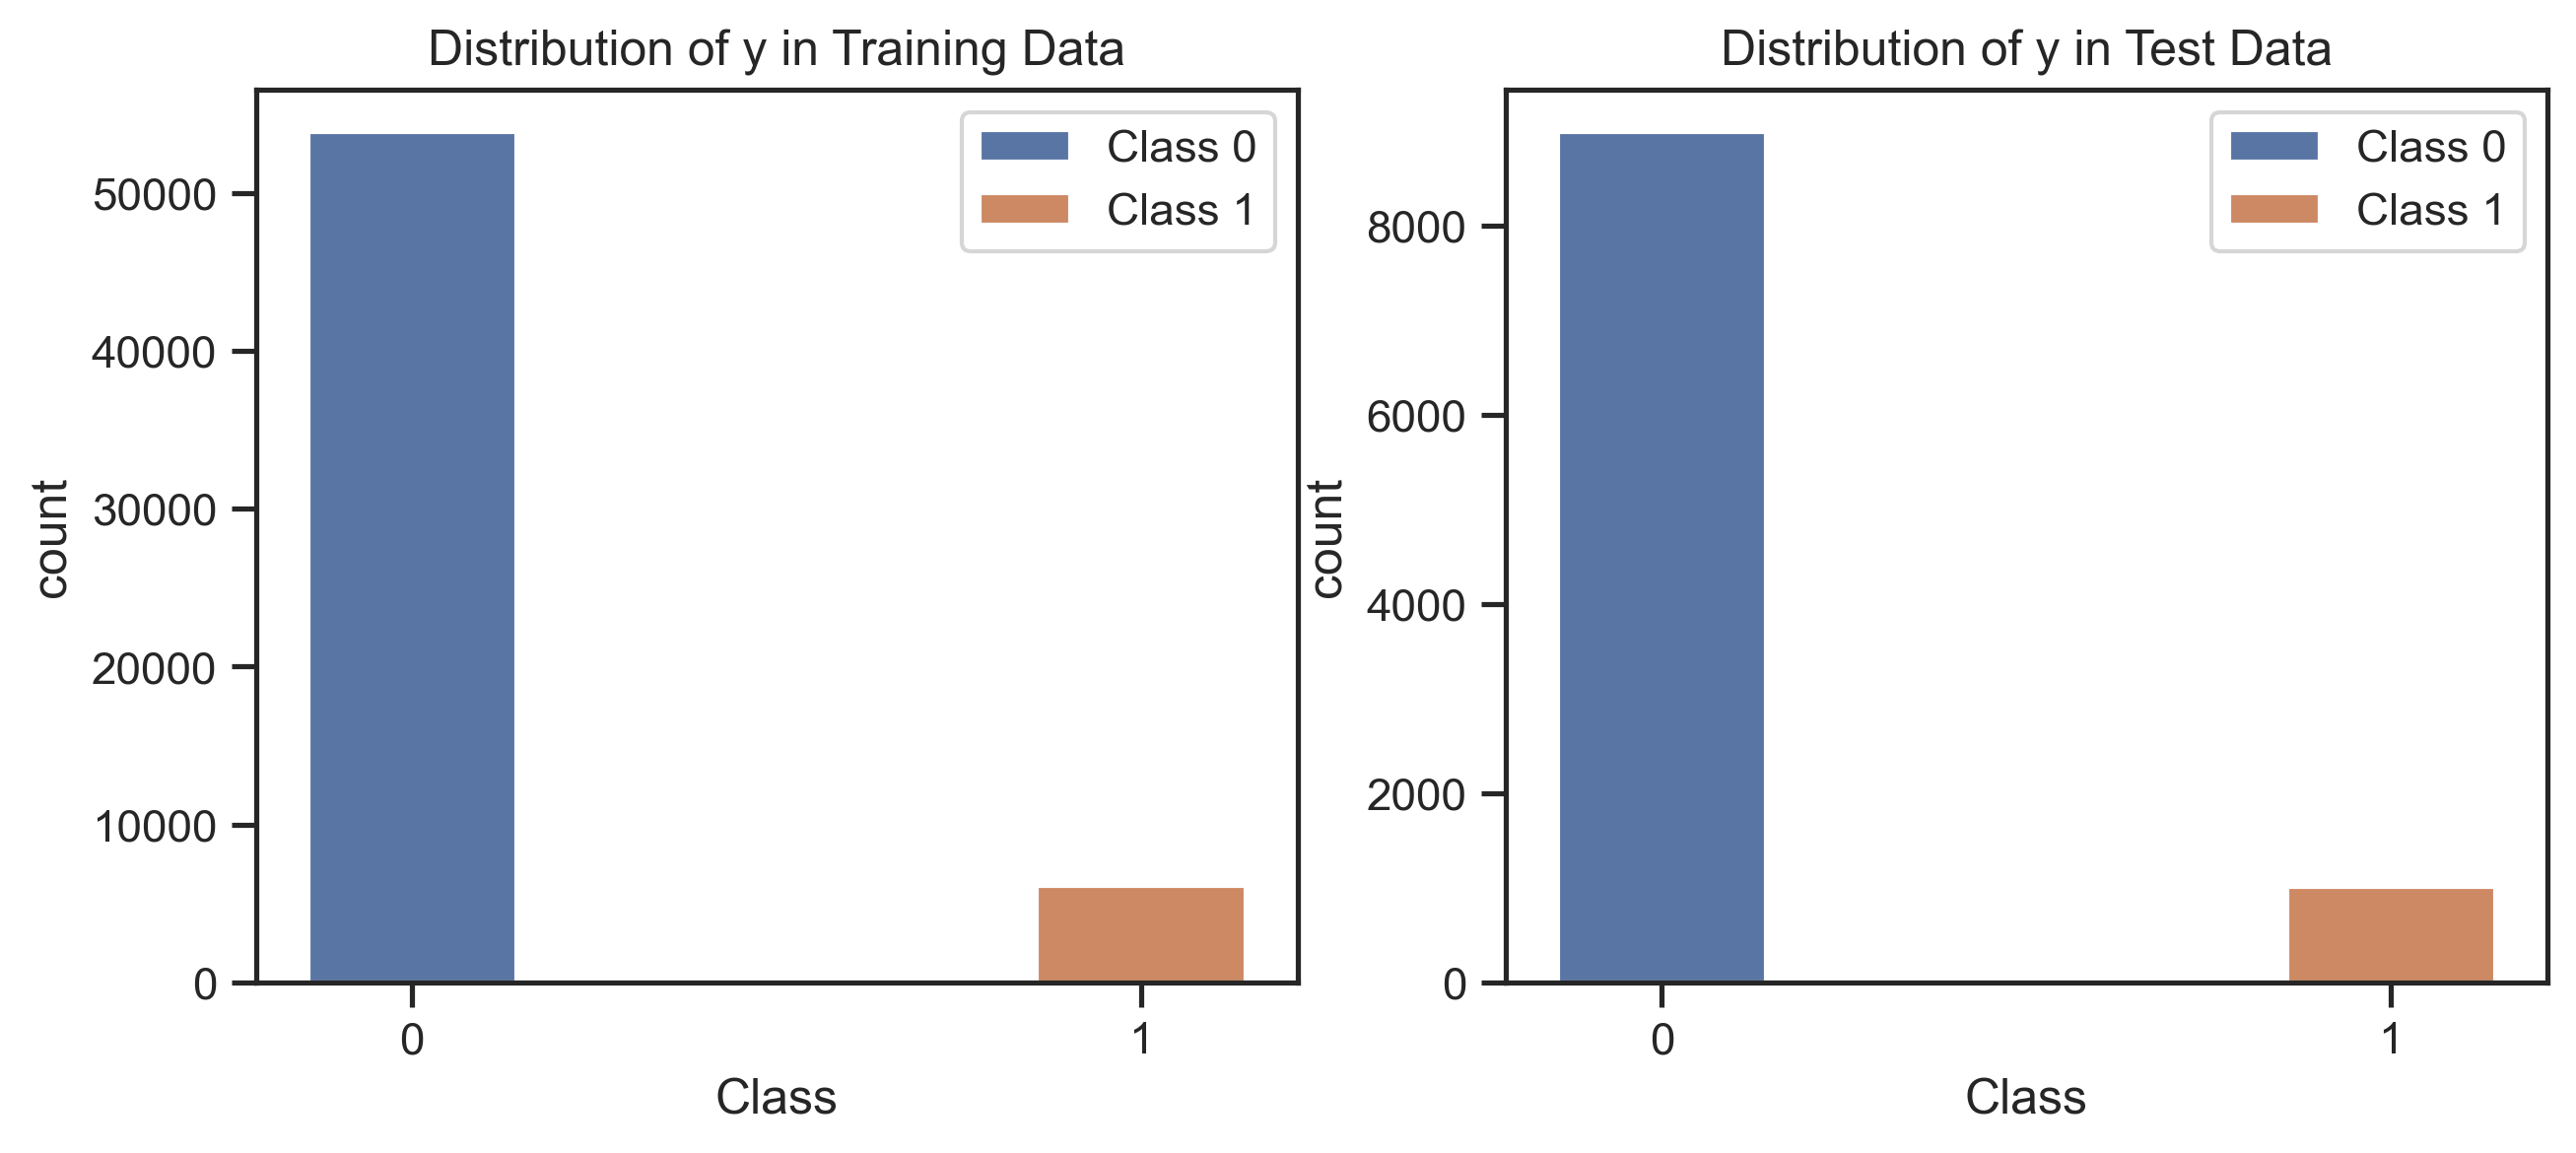

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=y_train, ax=axes[0], hue=y_train)
sns.countplot(x=y_test, ax=axes[1], hue=y_test)
axes[0].set_xlabel("Class")
axes[0].set_title("Distribution of y in Training Data")
axes[0].set_xticks([-0.2,1.2], ["0", "1"])
axes[0].legend(labels=["Class 0", "Class 1"])
axes[1].set_xlabel("Class")
axes[1].set_title("Distribution of y in Test Data")
axes[1].set_xticks([-0.2,1.2], ["0", "1"])
axes[1].legend(labels=["Class 0", "Class 1"])
plt.show()


In [67]:
# Print the percentage of each class
print(f"Class 1 samples represent {100 * y_train.mean():.2f}%"
        f" of the training set and {100 * y_test.mean():.2f}%"
        f" of the test set")
print(f"Class 0 samples represent {(1 - y_train.mean()) * 100:.2f}%"
        f" of the training set and {(1 - y_test.mean())*100:.2f}%"
        f" of the test set")

Class 1 samples represent 10.21% of the training set and 10.12% of the test set
Class 0 samples represent 89.78% of the training set and 89.88% of the test set


> We can see from the plot above that there are a lot more samples of Class 0 than there are of Class 1. Around 10.2% of the data are in our positive class class 1, and the rest are class 0. This proportion holds for both samples in the training data and the test data. This could be problematic because the model may not have ample data of samples in class 1 to be able to correctly predict positive test data in this class. 

##### (c) Optimize regularization parameters {-}

> We create 25 potential regularization parameters, varied logarithmically from $10^{-4}$ to $10^{4}$, in a numpy array C to fit the regressions. We then loop over each regularization parameter, fit the logistic regression model, and then append the performance metrics to empty lists.

In [68]:
# Import logistic regression module, log loss, auc, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, auc, f1_score, roc_curve

# Create vector of C that's logarithmically spaced
C = np.logspace(-4, 4, 25)
w_vectors = []
log_loss_scores = []
auc_scores = []
f1_scores = []

# Iterate over C and compute the performance metrics
for c in C:
    # Fit the logistic regression model
    log_reg_c = LogisticRegression(penalty="l1", C=c, solver="liblinear")
    log_reg_c.fit(X_train, y_train)
    # Output the w vector
    w_vectors.append(log_reg_c.coef_)
    # Make predictions
    # Pick the probability of class 1 (positive class)
    predicted_probs_test = log_reg_c.predict_proba(X_test)[:, 1]
    # Make predictions assumign threshold = 0.5
    predicted_test = np.where(predicted_probs_test > 0.5, 1, 0)
    # Append the log loss score
    log_loss_scores.append(log_loss(y_test, predicted_probs_test))
    # Calculate fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_test, predicted_probs_test)
    # Append the AUC score
    auc_scores.append(auc(fpr, tpr))
    # Append the f1 score
    f1_scores.append(f1_score(y_test, predicted_test))


> Plotting the number of non-zero model parameters, cross entropy loss, Area under the ROC curve, and the F1 score shows us how the model performs with each regularization parameter.

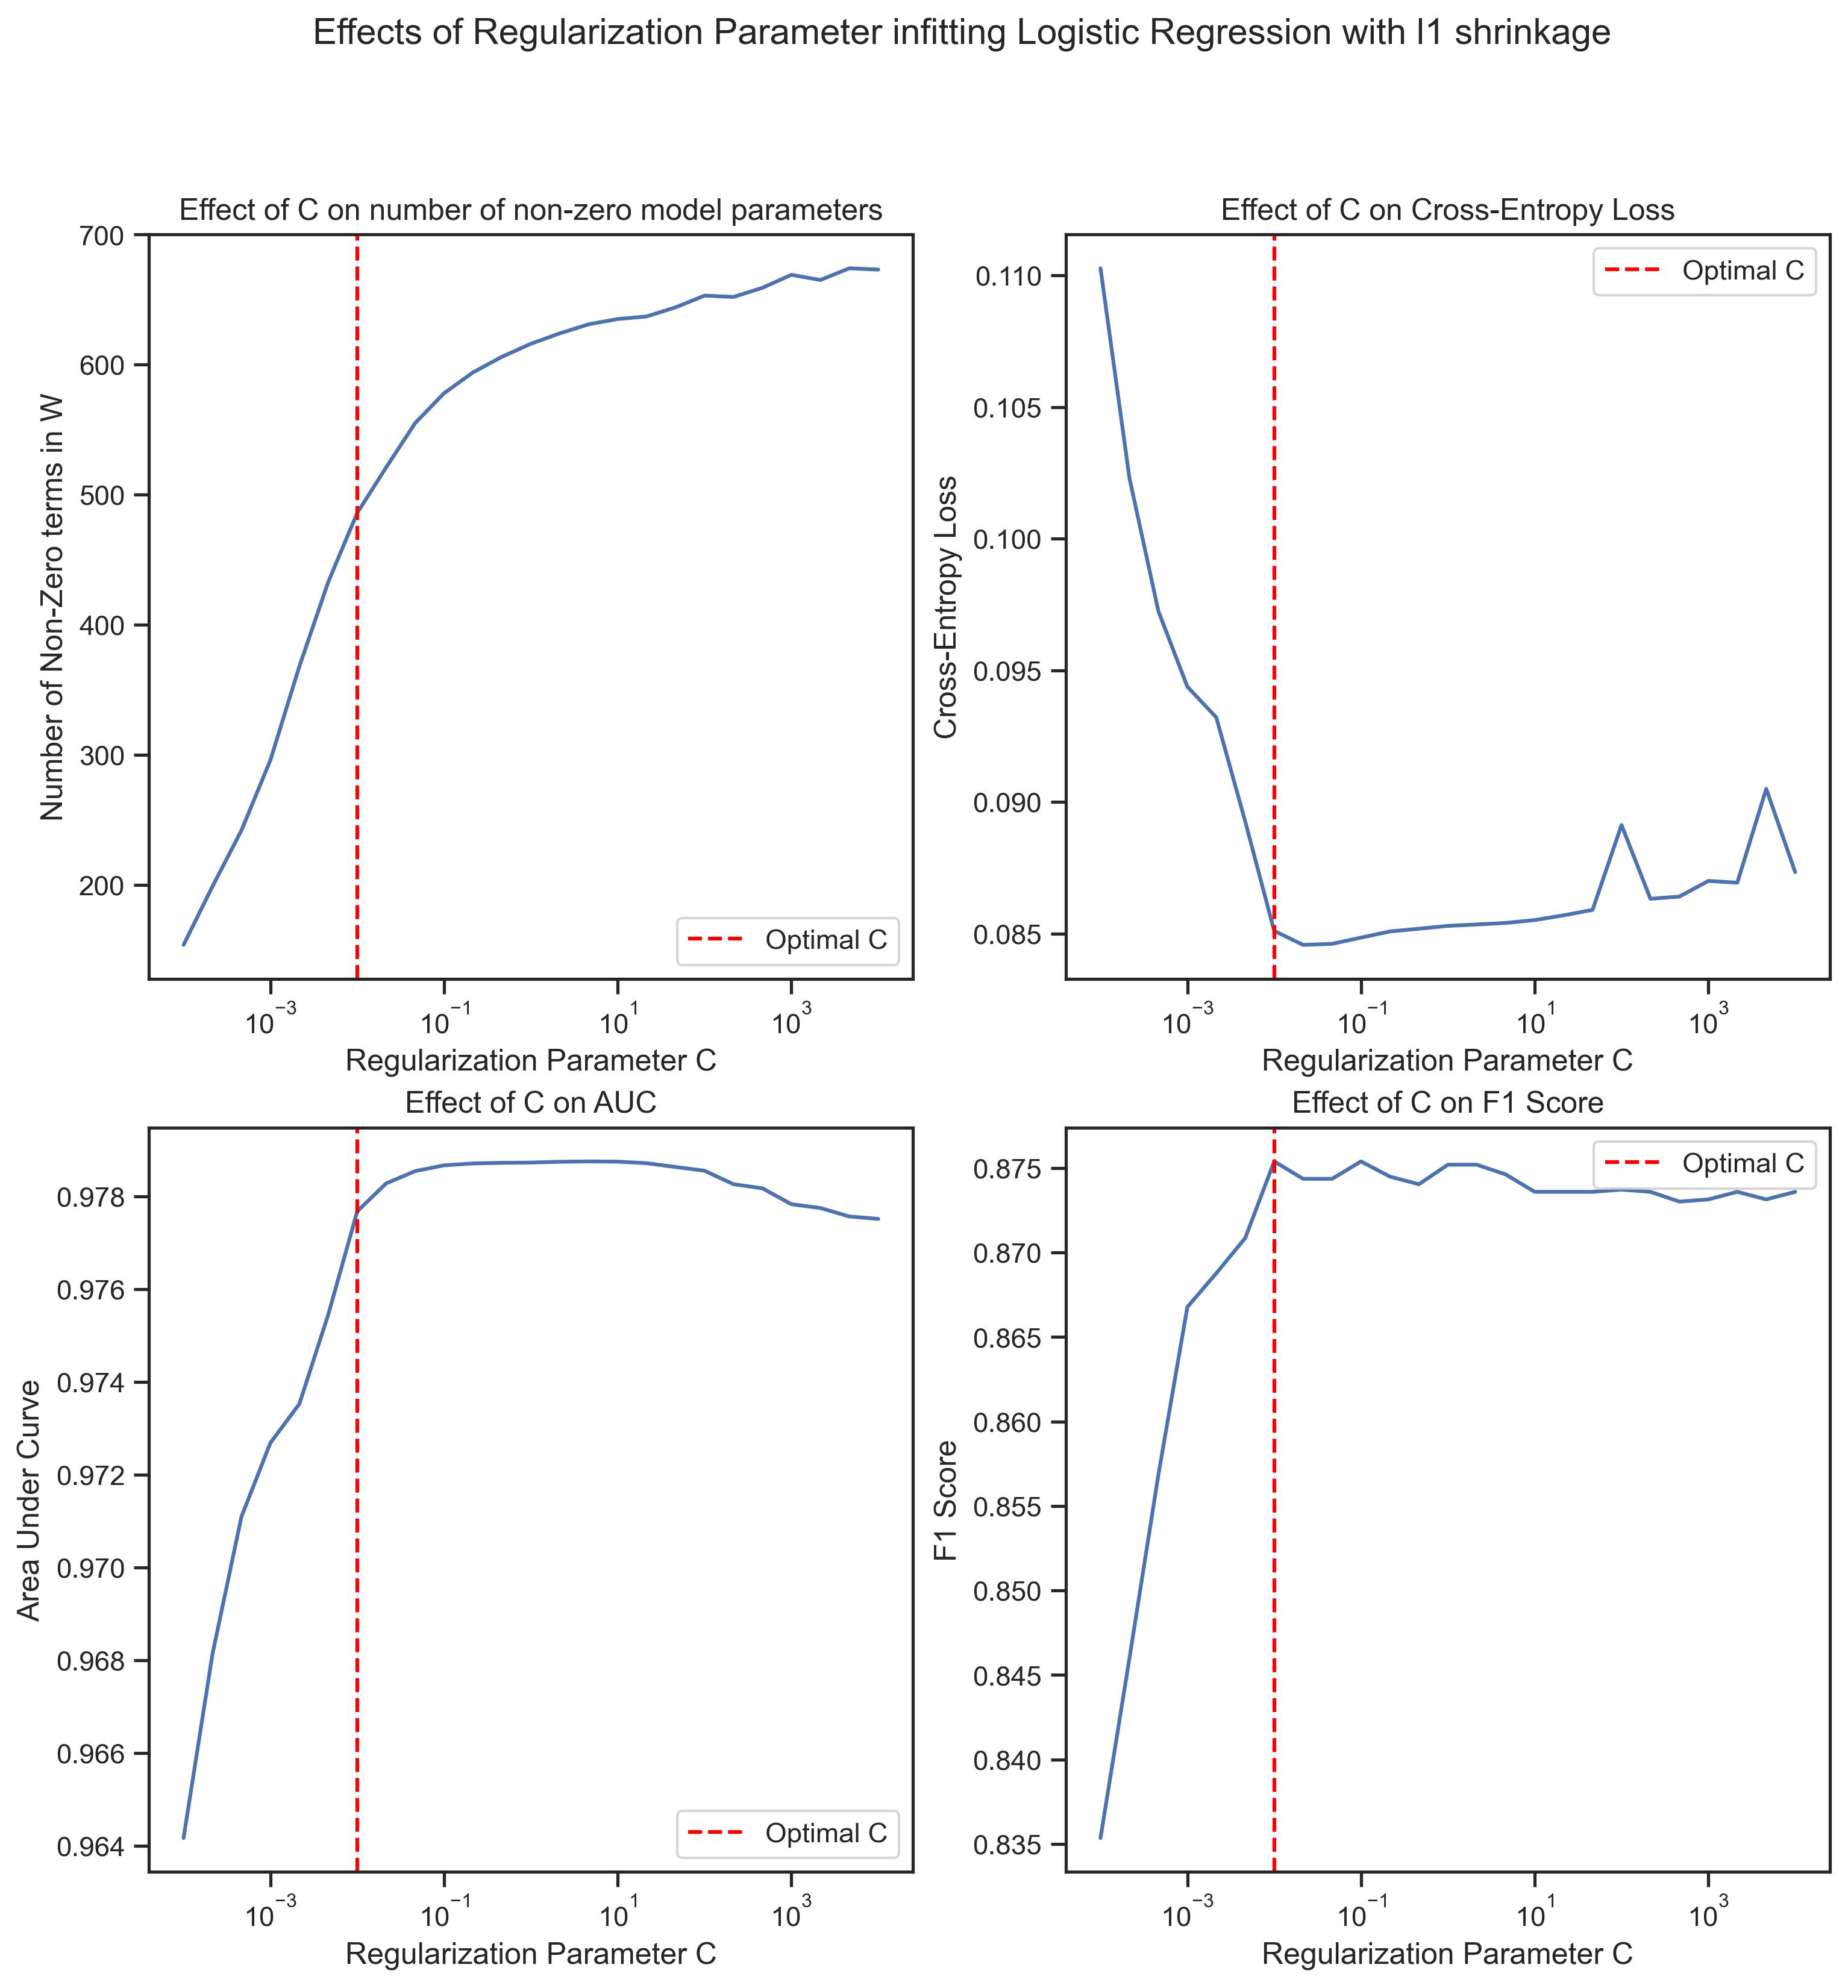

In [69]:
# For each w_vector get the number of non-zero weights
nonzeros = [len(w[w != 0]) for w in w_vectors]

# Plot the four metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
# Plot number of non-zero weights
axes[0, 0].plot(C, nonzeros)
axes[0, 0].axvline(x=1e-2, linestyle="--", c="red", label="Optimal C")
axes[0, 0].legend()
axes[0, 0].set_xscale("log")
axes[0, 0].set_xlabel("Regularization Parameter C")
axes[0, 0].set_ylabel("Number of Non-Zero terms in W")
axes[0, 0].set_title("Effect of C on number of non-zero model parameters")
# Plot log_loss scores
axes[0, 1].plot(C, log_loss_scores)
axes[0, 1].axvline(x=1e-2, linestyle="--", c="red", label="Optimal C")
axes[0, 1].set_xscale("log")
axes[0, 1].set_xlabel("Regularization Parameter C")
axes[0, 1].set_ylabel("Cross-Entropy Loss")
axes[0, 1].legend()
axes[0, 1].set_title("Effect of C on Cross-Entropy Loss")
# Plot auc scores
axes[1, 0].plot(C, auc_scores)
axes[1, 0].axvline(x=1e-2, linestyle="--", c="red", label="Optimal C")
axes[1, 0].legend()
axes[1, 0].set_xscale("log")
axes[1, 0].set_xlabel("Regularization Parameter C")
axes[1, 0].set_ylabel("Area Under Curve")
axes[1, 0].set_title("Effect of C on AUC")
# Plot f1 scores
axes[1, 1].plot(C, f1_scores)
axes[1, 1].axvline(x=1e-2, linestyle="--", c="red", label="Optimal C")
axes[1, 1].legend()
axes[1, 1].set_xscale("log")
axes[1, 1].set_xlabel("Regularization Parameter C")
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].set_title("Effect of C on F1 Score")
fig.suptitle(
    "Effects of Regularization Parameter in"
    "fitting Logistic Regression with l1 shrinkage"
)
plt.show()


> Referencing the plot above, I identified $10^{-2}$ as the optimal regularization parameter because it is the model with the least number of non-zero parameters that is still able to yield low cross-entropy loss, higher area under ROC curve and high F1 score. This allows us to use the least complex model to yield the best performance metrics.

##### (d) Test Logistic Regression, LDA, and Random Forest models {-}

> Here we import and fit a logistic regression with a really large C, a logistic regression with the optimal C that we identified in part (c), a Linear Discriminant Analysis model, and a Random Forest classifier on the training data.  

In [70]:
# Import LDA and Random Forest modules
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import PrecisionRecallDisplay

# Fit the logistic regression with a huge C
regression_no_reg = LogisticRegression(penalty="l1", C=1e100, 
    solver="liblinear")
regression_no_reg.fit(X_train, y_train)

# Fit the logistic regression with optimal C from the last section
regression_optimal_reg = LogisticRegression(penalty="l1", C=1e-2, 
    solver="liblinear")
regression_optimal_reg.fit(X_train, y_train)

# Fit the LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Fit the Random Forest model
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)


RandomForestClassifier()

> We then plot the ROC curves and the Precision-Recall curves of each of the models. Additionally, we plot the ROC and PR curves for when we are just randomly guessing the predicted responses: this is the chance diagonal on the ROC curve and simply the proportion of samples in class 1 for the PR curve. 

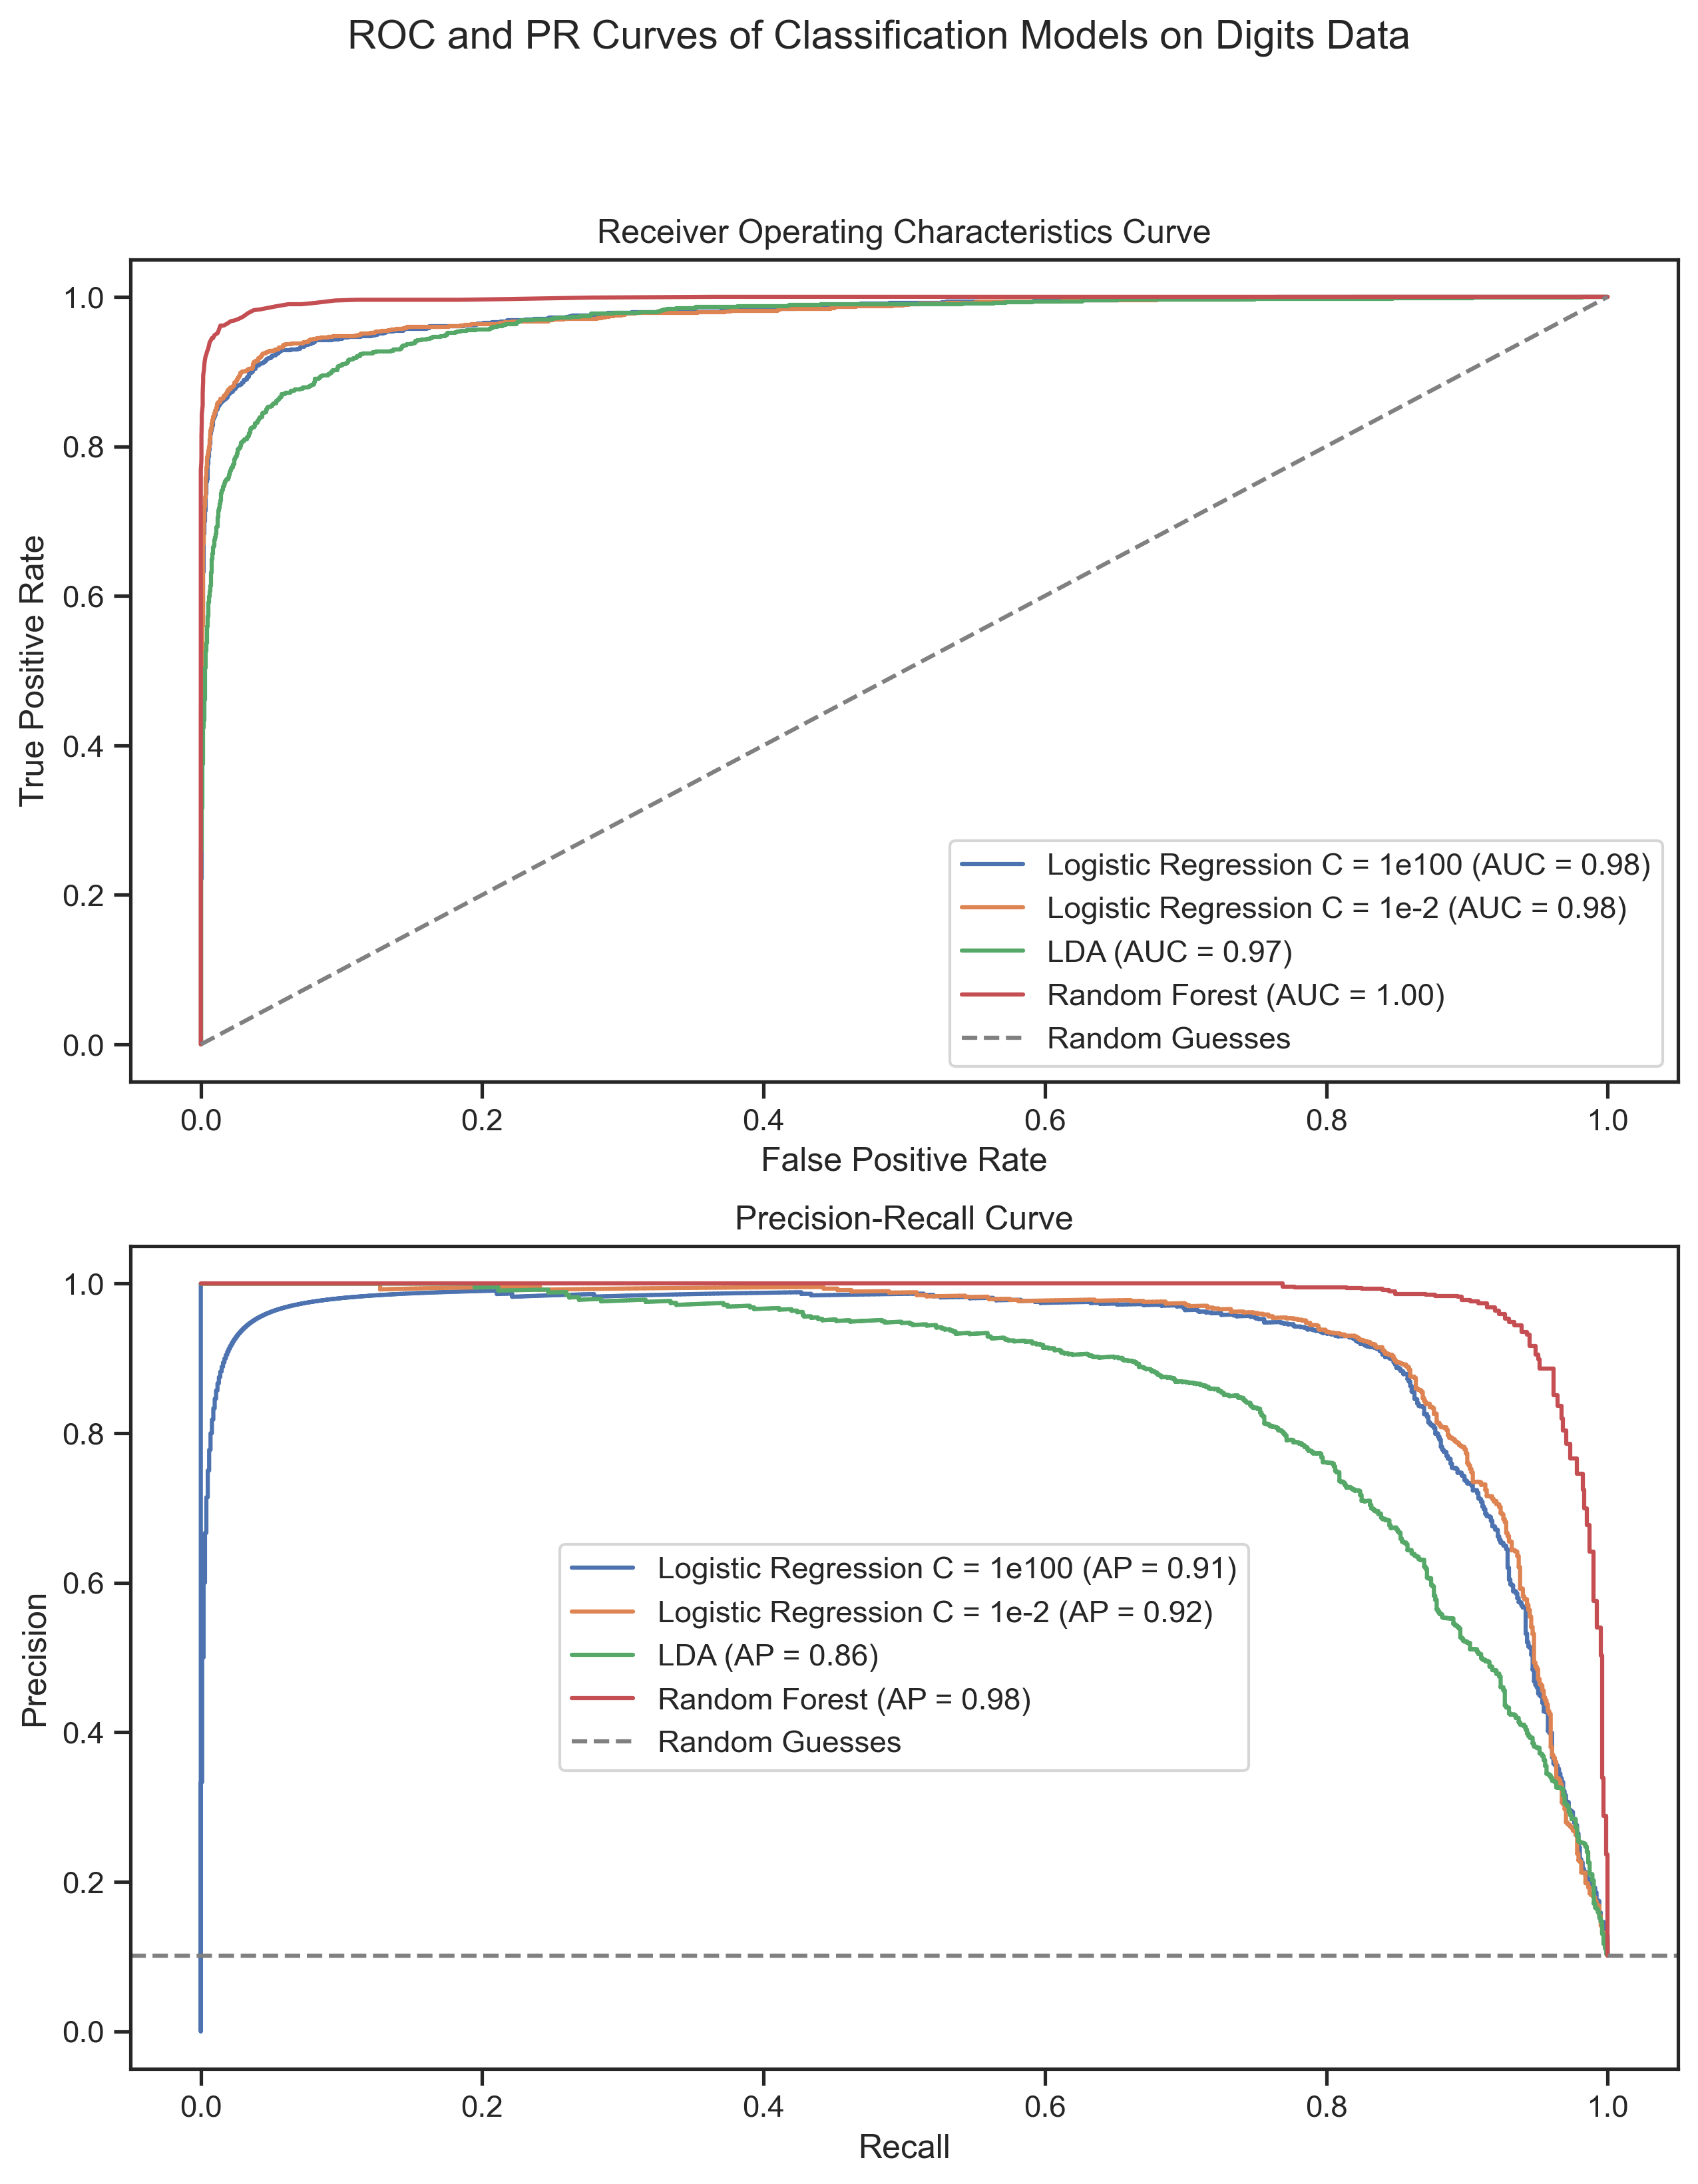

In [71]:
# Plot the ROC curves and PR curves
fig, axes = plt.subplots(2, 1, figsize=(10, 12))


# Plot the ROC Curves
RocCurveDisplay.from_estimator(
    regression_no_reg, X_test, y_test, ax=axes[0], 
    name="Logistic Regression C = 1e100"
)
RocCurveDisplay.from_estimator(
    regression_optimal_reg,
    X_test,
    y_test,
    ax=axes[0],
    name="Logistic Regression C = 1e-2",
)
RocCurveDisplay.from_estimator(lda, X_test, y_test, ax=axes[0], name="LDA")
RocCurveDisplay.from_estimator(
    randomforest, X_test, y_test, ax=axes[0], name="Random Forest"
)
axes[0].plot(
    chance[:, 0], chance[:, 1], linestyle="dashed", 
    c="gray", label="Random Guesses"
)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("Receiver Operating Characteristics Curve")
axes[0].legend()

# Plot the PR Curves
PrecisionRecallDisplay.from_estimator(
    regression_no_reg, X_test, y_test, 
    ax=axes[1], name="Logistic Regression C = 1e100"
)
PrecisionRecallDisplay.from_estimator(
    regression_optimal_reg,
    X_test,
    y_test,
    ax=axes[1],
    name="Logistic Regression C = 1e-2",
)
PrecisionRecallDisplay.from_estimator(
    lda, X_test, y_test, ax=axes[1], name="LDA")
PrecisionRecallDisplay.from_estimator(
    randomforest, X_test, y_test, ax=axes[1], name="Random Forest"
)
axes[1].axhline(
    y=y_test.mean(), linestyle="dashed", 
    c="gray", label="Random Guesses")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()
fig.suptitle("ROC and PR Curves of Classification Models on Digits Data")
plt.show()


> Among the classifiers that we compared, random forest model performed consistently the best in both the ROC curve and the PR curve. The logistic regressions, regardless of their regularization, performed slightly worse than the random forest model but still well. LDA did not perform as well as the rest of the models. Regularization did not make too much of a difference, however, it pushed the Area under curve of the PR curve slightly higher than the model without regularization, but did not have a lot of impact on the model's performance.  We would select the random forest model for application to unseen data because it performed the best on unseen data.